# PHYS20762 Computational Physics
Project 3: Monte Carlo Techniques\
Neutron Transport and Scattering Through a Shielding Layer\
Ethan Wong\
10455801\
University of Manchester\
March 2023

# Introduction

This project aims to develop a simulation of thermal neutron penetration through a slab of shielding through lead, water and graphite, considering absorption and scattering processes. The notebook is organized into several tasks:

1) Generate arrays of numbers using numpy.random.uniform() and confirm the uniform distribution over a chosen range.<br>
2) Create a script that generates a 3D array of random points and display them using an interactive scatter plot. Verify the absence of spectral issues and compare it with the randssp.ipynb results.<br>
3) Develop a random number generator that produces samples distributed according to an exponential function. Calculate the characteristic attenuation length for water and include representative plots.<br>
4) Write a function to produce isotropic unit vectors and visually assess their uniform distribution using an interactive scatter plot.<br>
5) Create a new function to generate isotropic steps with lengths distributed according to the exponential function.<br>
6) Visualize the random walk of a few neutrons through each material, considering absorption and scattering.<br>
7) Simulate the process for 10,000 neutrons to determine absorption, reflection, and transmission rates, as well as their uncertainties.<br>
8) Plot the variation in neutron transmission, reflection, and absorption rates with slab thickness for the three materials.<br>
9) Determine the characteristic attenuation lengths and their estimated errors for the three materials from their corresponding transmission rates. Include a summary of numerical data and representative graphs.<br>
10) Use the Woodcock method to simulate a neutron travelling through two different materials.

## Defining variables

In [1]:
import numpy as np
from numpy.random import uniform as uni
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm.notebook import tnrange
import pandas as pd

%matplotlib inline

N_PARTICLES = 10000
ITERATIONS = 10
BINS = 30
ABS_WATER_ATT_LENGTH = 45
AVOGADRO = 6.02214 *10 **23

# Parameters of water
ABS_CROSS_WATER = 0.6652 * 10 ** -24
SCAT_CROSS_WATER = 103.0 * 10 ** -24
DENSITY_WATER = 1.00 
MOLAR_MASS_WATER = 18.0153

# Parameters of lead
ABS_CROSS_LEAD = 0.158 * 10 ** -24
SCAT_CROSS_LEAD = 11.221 * 10 ** -24
DENSITY_LEAD = 11.35
MOLAR_MASS_LEAD = 207.2

# Parameters of graphite
ABS_CROSS_GRAPHITE = 0.0045 * 10 ** -24
SCAT_CROSS_GRAPHITE = 4.74 * 10 ** -24
DENSITY_GRAPHITE = 1.67
MOLAR_MASS_GRAPHITE = 12.011

# The slabs thickness was taken as 20cm 
VARIABLE_THICKNESS = np.linspace(1,20,100) 
MAXIMUM_THICKNESS = 20


plt.rcParams.update({'font.size': 14})
plt.style.use('default')

<p>Absorption Cross Section (in units barns): This is a measure of the probability that a neutron will be absorbed by a nucleus. It essentially represents the "target area" that the nucleus presents to incoming neutrons. The unit of measurement, the barn, is equal to 10^-28 square meters, which is a convenient unit for these microscopic cross-sectional areas. A higher absorption cross section means a higher probability of neutron absorption.</p>
<p>Scattering Cross Section (in units barns): Similar to the absorption cross section, this is a measure of the probability that a neutron will be scattered (i.e., deflected off its original path without being absorbed) by a nucleus. Again, it represents the "target area" that the nucleus presents to incoming neutrons for scattering interactions. A higher scattering cross section means a higher probability of neutron scattering.</p>
<p>Density (in g/cm^3): This is the mass of the material per unit volume. In the context of neutron interactions, a higher density means a higher number of nuclei per unit volume, and thus a higher probability of neutron interactions (both absorption and scattering) occurring.</p>
<p>Molar Mass (in g/mol): This is the mass of one mole (approximately 6.022 x 10^23 particles) of a substance. It's equivalent to the atomic or molecular weight of the substance expressed in grams. In the context of neutron interactions, it can be used along with the density and Avogadro's number to calculate the number of nuclei per unit volume, which in turn affects the probability of neutron interactions.</p>

The absorption and scattering cross sections were converted from barns to cm^2 by multiplying by a factor 10^-24.

# 1) Creating random number generators

Our first task is to confirm that we can generate arrays of numbers using Python's in-built random number generator, numpy.random.uniform(). This function plays a critical role in our project, as it allows us to generate random numbers that are uniformly distributed over a specific range. 

A uniform distribution is a type of probability distribution in which all outcomes are equally likely. In other words, in a perfect uniform distribution, each possible value within the defined range should appear approximately the same number of times when sampled sufficiently.

The histogram is a powerful tool that we can use to visualize and confirm the uniformity of our distribution. When we generate a large number of random values using numpy.random.uniform(), we can use a histogram to group these values into bins and count how many values fall into each bin.

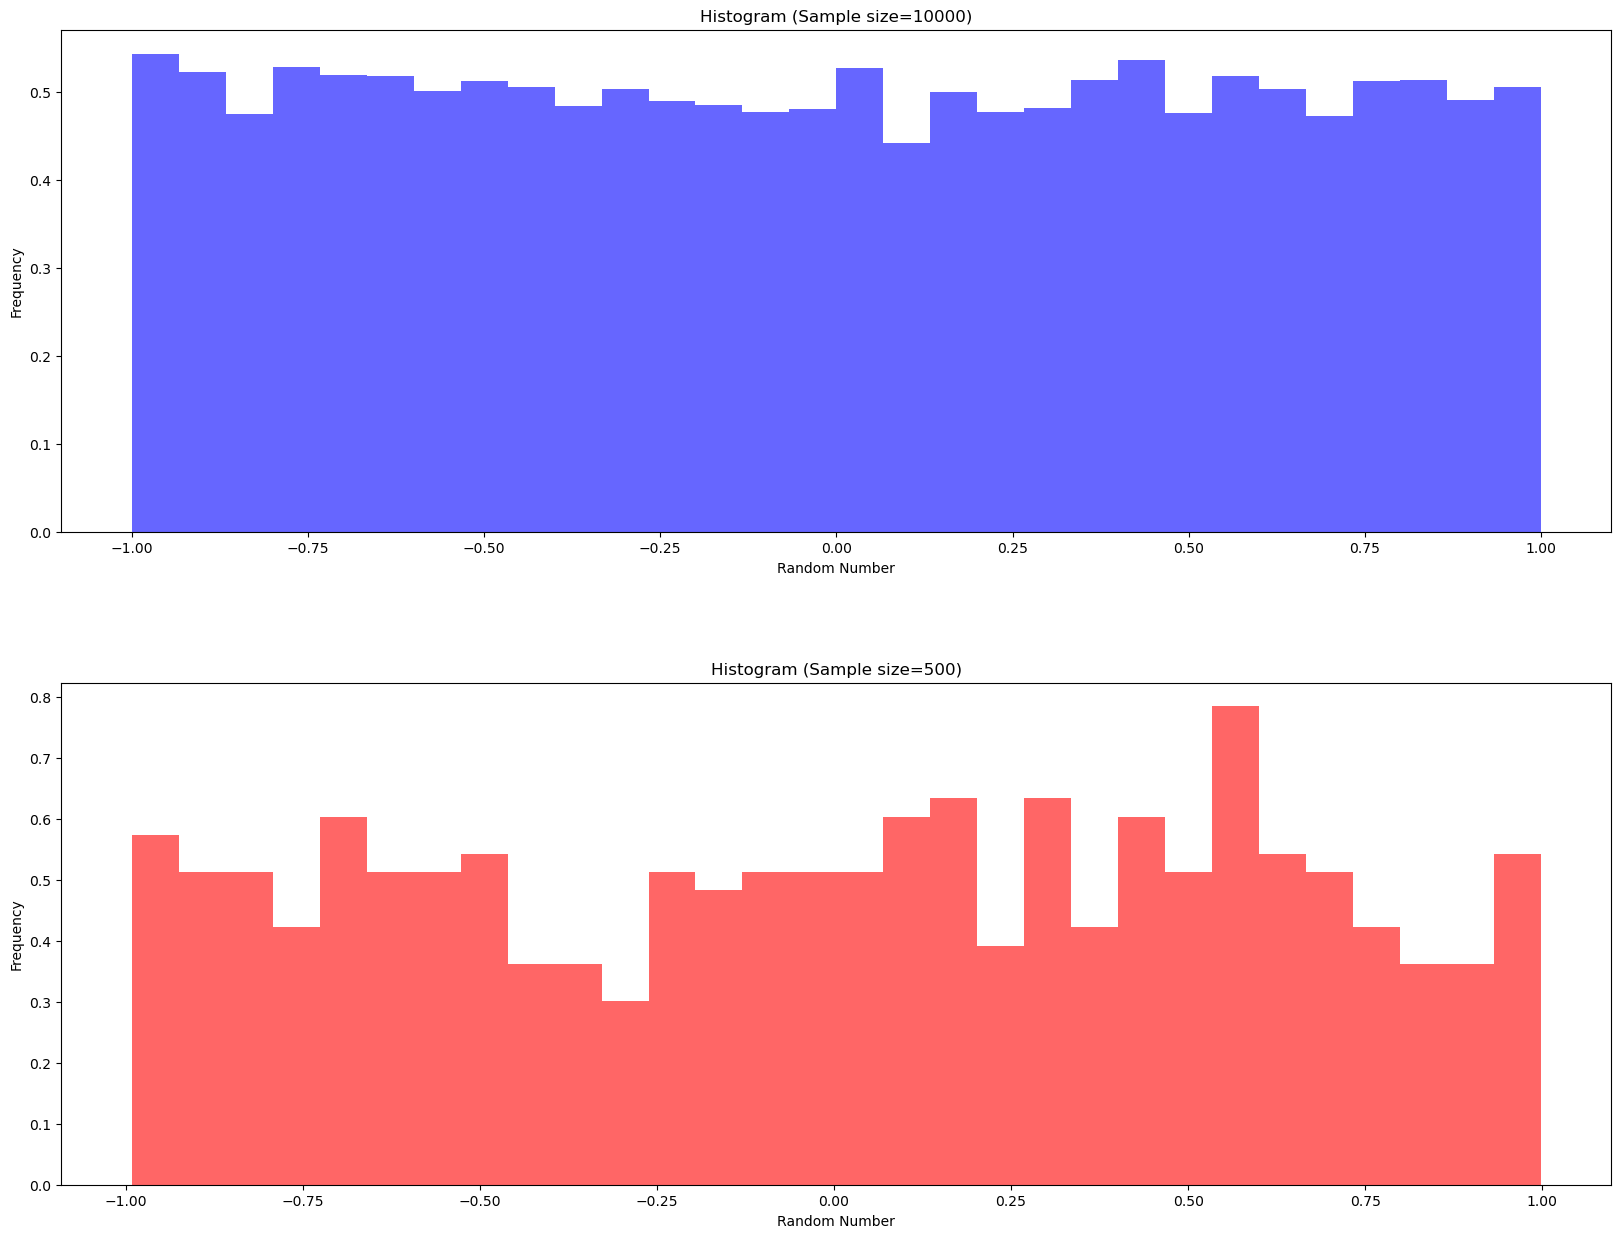

In [2]:
# Create 2 arrays: one with 10000 random numbers and one with 500
RANDOM_NUMBERS_BIG = uni(-1,1,(10000))
RANDOM_NUMBERS_SMALL = uni(-1,1,(500))

# Plot the random numbers on a histogram to show if they have a uniform distribution
figure_1, axis_1 = plt.subplots(2, figsize=(20,15))
axis_1[0].hist(RANDOM_NUMBERS_BIG, bins=BINS, density=True, alpha=0.6, color='b')
axis_1[0].set_xlabel('Random Number')
axis_1[0].set_ylabel('Frequency')
axis_1[0].set_title('Histogram (Sample size=10000)')

axis_1[1].hist(RANDOM_NUMBERS_SMALL, bins=BINS, density=True, alpha=0.6, color='r')
axis_1[1].set_xlabel('Random Number')
axis_1[1].set_ylabel('Frequency')
axis_1[1].set_title('Histogram (Sample size=500)')

plt.subplots_adjust(hspace=0.3) 
plt.show()

The histogram with a sample size of 10000 shows approximately equal heights for all bins, indicative of a uniform distribution. This is because, in a uniform distribution, each interval of equal size has the same probability of containing a randomly drawn number. This suggests the random number generator is working correctly for a large sample size.

However, for the histogram with a sample size of 500 the bin heights are not all equal. This is due to the sample size being to small, thus statistical fluctuations might cause some bins to contain more numbers than others, leading to a histogram that doesn't look perfectly uniform. These fluctuations decrease as we increase the sample size, allowing the true uniform distribution to emerge.

# 2) Investigating spectral issues

In this section of the project, we aim to generate a three-dimensional array of random points, each of which will have coordinates (x, y, z) drawn from a uniform distribution. This task will leverage the numpy.random.uniform() function, which returns values that follow a uniform distribution within a specified range.

A critical part of this task is visualizing the generated points using an interactive scatter plot. This type of plot allows us to explore the spatial distribution of our random points in a three-dimensional space, by rotating the plot and zooming in and out to observe the data from different angles. Such a visualization is crucial for us to confirm that the points are indeed randomly distributed without any noticeable patterns or clusters, confirming the absence of spectral issues.

Spectral issues are patterns that appear in the data due to the limitations of the random number generator. They manifest as unanticipated regularities or correlations in the supposedly random data. For instance, in a 3D scatter plot of random points, spectral issues might be apparent as planes, lines, or other structures where the points are more densely or sparsely populated. A linear congruential generator is used to demonstrate these spectral issues.

<IPython.core.display.Javascript object>


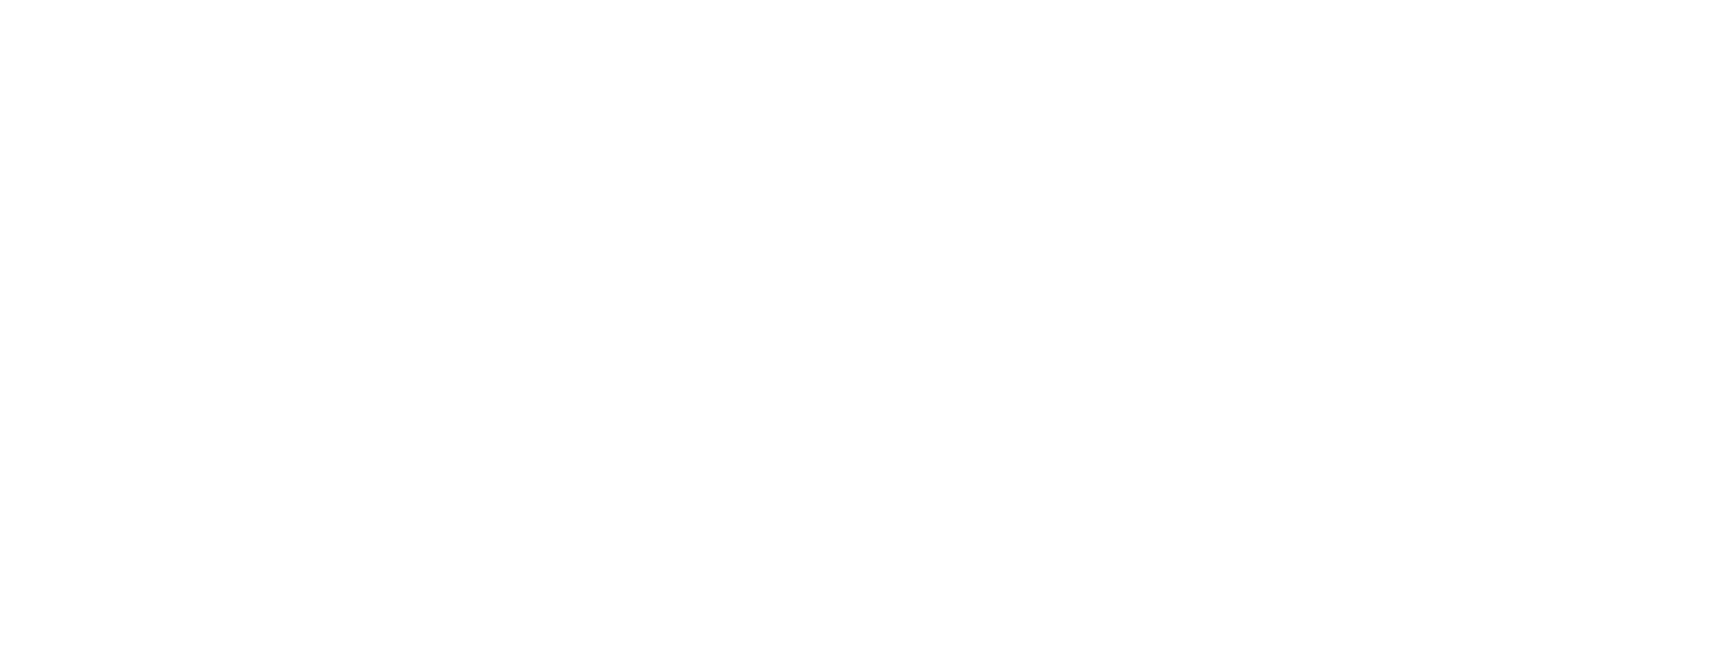

In [3]:
%matplotlib notebook
%matplotlib notebook

def linear_congruential_generator(n_rows, n_cols, seed=123456789, modulus=pow(2, 31), multiplier=pow(2, 16) + 3, increment=0):
    """
    Generate a matrix of random numbers using linear congruential generator that shows spectral issues.

    Args:
        n_rows (int): Number of rows in the output matrix.
        n_cols (int): Number of columns in the output matrix.
        seed (int, optional): The initial seed for the random number generator. Default is 123456789.
        modulus (int, optional): The modulus parameter for the generator. Default is 2^31.
        multiplier (int, optional): The multiplier parameter for the generator. Default is 2^16 + 3.
        increment (int, optional): The increment parameter for the generator. Default is 0.

    Returns:
        numpy.ndarray: A matrix of size [n_rows, n_cols] containing random numbers between 0 and 1.
    """
    
    random_numbers = np.zeros([n_rows, n_cols])
    current_seed = seed

    for col in range(n_cols):
        for row in range(n_rows):
            current_seed = (multiplier * current_seed + increment) % modulus
            random_numbers[row, col] = current_seed / modulus

    return random_numbers

# Create random points in 3D
(random_x, random_y, random_z) = uni(-1,1,(3,1000))

# Create a figure
fig_2 = plt.figure(figsize=(16,6))

# First subplot
axis_2a = fig_2.add_subplot(121, projection='3d')
axis_2a.scatter(random_x, random_y, random_z, color='r')
axis_2a.set_xlabel('x')
axis_2a.set_ylabel('y')
axis_2a.set_zlabel('z')
axis_2a.set_title("3D generated random points")

random_matrix = linear_congruential_generator(3, 1500)
# Second subplot
axis_2b = fig_2.add_subplot(122, projection='3d')
axis_2b.scatter(random_matrix[0, :], random_matrix[1, :], random_matrix[2, :], color='r')
axis_2b.set_xlabel('x')
axis_2b.set_ylabel('y')
axis_2b.set_zlabel('z')
axis_2b.set_title("Spectral issues from a random generator")
axis_2b.view_init(elev=-82, azim=4)

plt.show()

In [4]:
%matplotlib inline

The first plot is generated by independently drawing three coordinates (x, y, and z) for each point from a uniform distribution over the interval [-1, 1]. This method assumes that there is no correlation between the different dimensions, resulting in a random "cloud" of points that is roughly evenly distributed throughout the 3D space.

The second plot, however used a Linear Congruential Generator (LCG) which is a type of pseudorandom number generator, a simple and efficient method widely used for generating sequences of random numbers. The generator is defined by the recurrence relation:

$$X_{(n+1)} = (aX_n + c)\, mod \,m$$

where 'X' is the sequence of pseudorandom values, and 'a', 'c', and 'm' are generator-specific constants. 

However, LCGs have a notable property, called Marsaglia's theorem, which states that all LCGs produce points that lie on a set of hyperplanes in a higher-dimensional space. Essentially, for any dimension 'k', there exist 'k'-dimensional planes such that each 'k'-tuple of successive values from the LCG lies on one of these planes. This means that there are correlations between the points, which can be problematic when the generator is used in certain applications, such as in Monte Carlo simulations, that require independent random numbers. From the plot we can infer that it introduces some form of correlation or regularity among the points, resulting in a pattern that resembles spectral lines. Instead of being evenly spread out in the 3D space, the points seem to align along certain directions or planes, creating a more structured appearance.

# 3) Random number samples following an exponential distribution

In this section of the project, the aim is to develop a random number generator that generates samples based on an exponential function $$exp(-x/λ)$$ where λ represents the mean free path.
The generator will be used to show that, without scattering, the characteristic attenuation length for water is approximately 45 cm. The parameters defined at the beginning of the project will be used. 
To demonstrate this, numpy.histogram will be used to bin the generated points and then a weighted linear numpy.polyfit will be peformed on the binned data to determine the attenuation length and its expected uncertainty.


## Cumulative Distribution function of an exponential function

The aim is to create a random number generator that generates numbers following an exponential distribution. To achieve this a Cumulative Distribution Function (CDF) is used. CDF is a statistical function that describes the probability that a random variable is equal to or less than a certain value. The CDF for a random variable is defined as the probability that the variable takes a value less than or equal to a certain value. For a continuous random variable, the CDF is the integral (or area under the curve) of its Probability Density Function (PDF) up to a certain point. The inverse distribution method leverages the properties of the CDF. Specifically, the method involves integrating the PDF of the desired distribution to obtain the CDF, then inverting this function to get the inverse CDF. If a uniformly distributed random variable is passed through the inverse CDF, the output will follow the original distribution defined by the PDF. This is because the CDF maps the original distribution to a uniform distribution, and so its inverse maps a uniform distribution back to the original distribution. 

The PDF of an exponential distribution is $$PDF(x) = e^{-x}$$ Integrating the PDF gives the CDF $$CDF(x)=\int_{0}^{x}PDF(x)=1-e^{-x}$$Taking the inverse of the CDF gives $$CDF^{-1}(z)=-ln(1-z)$$ so by inputting multiple random numbers into the inverse CDF an exponential distribution will be formed. Applying this method to the context of the project will give a PDF of $$P(x)=e^{-x/λ}$$ and a CDF of $$s_i=-λlog(u_i)$$ where λ is the mean free path of the neutron in a material, u is a random number between 1 and 0 and s is the step size.


The mean free path of a neutron travelling through 10cm of water, without considering scattering interations, 
is 44.65 ± 0.22 cm.


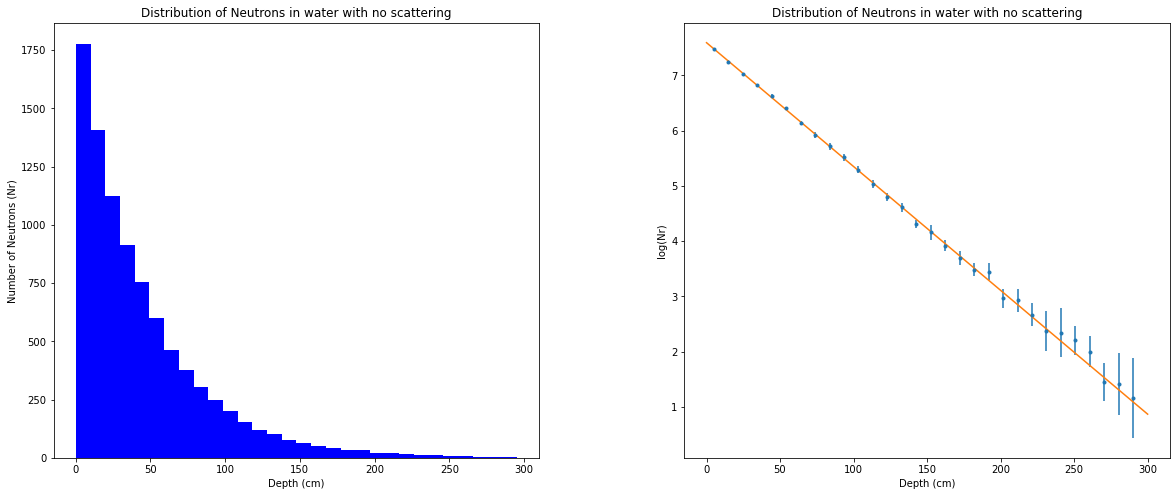

In [5]:
def exp_inv_cdf_histogram(n, n_iter, n_bins, r_max, lam):
    """
    Calculate the inverse cumulative distribution function (CDF) of the exponential function based on given parameters.

    Args:
    - n (int): Number of random numbers to generate.
    - n_iter (int): Number of iterations to perform.
    - n_bins (int): Number of bins for the histogram.
    - R_MAX (float): Maximum value for the range of the histogram.
    - lam (float): The attenuation length or rate parameter of the exponential distribution.

    Returns:
    - tuple: A tuple containing the following elements:
        - r (ndarray): An array of bin edges for the histogram.
        - log_mean (ndarray): The natural logarithm of the mean frequency for each bin.
        - mean_freq (ndarray): The mean frequency for each bin.
        - std_freq (ndarray): The standard deviation of the frequency for each bin.
        - error (ndarray): The error of the frequency for each bin, calculated as the ratio of the standard deviation to the mean frequency.
    """
    
    nr = np.zeros((n_iter, n_bins))
    r = np.zeros(n_bins)
    
    for i in range(n_iter):
        nr[i,:], r = np.histogram(-lam*np.log(uni(0,1,n)), range=(5, r_max), bins=n_bins)
    r = r[:-1]
    
    mean_freq = np.mean(nr, axis=0)
    std_freq = np.std(nr, axis=0)
    
        
    non_zero_indices = np.argwhere(mean_freq != 0).flatten()
    r = r[non_zero_indices]
    mean_freq = mean_freq[non_zero_indices]
    std_freq = std_freq[non_zero_indices]

    log_mean = np.log(mean_freq)
    error = std_freq / mean_freq 
        
    return (r, log_mean, mean_freq, std_freq, error)


R_MAX = 300
EXP_DIST = exp_inv_cdf_histogram(N_PARTICLES, ITERATIONS, BINS, R_MAX, ABS_WATER_ATT_LENGTH)

figure_3, axis_3 = plt.subplots(1, 2, figsize=(20,8))  # Note the change here

axis_3[0].bar(EXP_DIST[0], EXP_DIST[2], width=R_MAX/BINS, color='b')  # Changed from plt.hist to plt.bar
axis_3[0].set_xlabel('Depth (cm)')
axis_3[0].set_ylabel('Number of Neutrons (Nr)')
axis_3[0].set_title('Distribution of Neutrons in water with no scattering')

# Linear weighted fit 
COEFFS_EXP, COV_EXP = np.polyfit(EXP_DIST[0], EXP_DIST[1], deg=1, w=1/EXP_DIST[4],cov=True)
SLOPE_EXP, INTER_EXP = COEFFS_EXP
SLOPE_EXP_ERR, INTER_EXP_ERR = np.sqrt(np.diag(COV_EXP))

FREE_PATH = -1/SLOPE_EXP
ERR_FREE_PATH = abs(FREE_PATH*(SLOPE_EXP_ERR/SLOPE_EXP))
print("""The mean free path of a neutron travelling through 10cm of water, without considering scattering interations, 
is {0:.2f} ± {1:.2f} cm.""".format(FREE_PATH, ERR_FREE_PATH))

DEPTH = np.linspace(0,300,100)
axis_3[1].errorbar(EXP_DIST[0], EXP_DIST[1], yerr=EXP_DIST[4], fmt='.')
axis_3[1].plot(DEPTH, SLOPE_EXP*DEPTH+INTER_EXP)
axis_3[1].set_xlabel('Depth (cm)')
axis_3[1].set_ylabel('log(Nr)')
axis_3[1].set_title('Distribution of Neutrons in water with no scattering')

plt.subplots_adjust(wspace=0.3) 
plt.show()

The `exp_inv_cdf_histogram` function performs the core part of this simulation. It generates a series of histograms, each representing a different iteration of the simulation. In each iteration, the function generates a set of random numbers following an exponential distribution, and then counts the number of these numbers (representing neutrons) falling into each bin of the histogram. This is done by applying the inverse cumulative distribution function (CDF) of the exponential distribution to the random numbers, effectively converting them to distances that the neutrons travel in the medium. The histogram then provides a statistical representation of these distances.

The function performs `n_iter` iterations of this process, each time generating a new histogram. This is to account for the inherent randomness in the neutron behavior - by repeating the simulation multiple times, the function can capture a more accurate and robust picture of the overall neutron distribution.

The function then calculates the mean frequency (number of neutrons) for each bin across all iterations, and also the standard deviation and error of these frequencies. The mean frequency gives an overall estimate of the neutron distribution as a function of depth in the medium, while the standard deviation and error provide a measure of the uncertainty in this estimate.

Finally, the function returns these results, along with the bin edges of the histogram and the natural logarithm of the mean frequencies. 

In the main part of the code, these results are used to estimate the mean free path of the neutrons in the medium. This is done by fitting a line to the logarithm of the mean frequencies versus the depth, weighted by the inverse of the error. The slope of this line gives the decay rate of the neutron distribution with depth, from which the mean free path can be estimated.

# 4) Producing isotropic unit vectors

This section of the project delves further into the geometrical aspect of neutron scattering simulation by developing a function to generate isotropic unit vectors. Isotropic unit vectors, by definition, are vectors of length one that are evenly distributed in all directions in three-dimensional space. This concept is fundamental to the simulation as it mimics the random, isotropic nature of neutron scattering.

The unit vectors are construced as a sum of three components, each corresponding to one of the Cartesian coordinates (x, y, z). To ensure the vectors are uniformly distributed over a sphere, the vectors are generated using spherical polar coordinates, which are a natural choice for describing points on a sphere, and then convert to Cartesian coordinates using trigonometric relationships.

The generated unit vectors will be visually assessed using an interactive scatter plot to confirm their isotropic distribution over a sphere. This step is crucial to ensure the validity of our simulation model.

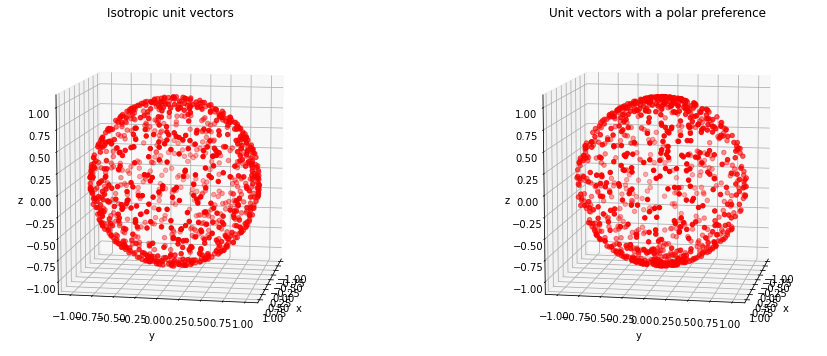

In [6]:
def inverse_trig_cdf(random_number):
    """
    Calculate the inverse cumulative distribution function (CDF) of the trigonometric function.

    Args:
    - random_number (float): A random number between 0 and 1, typically generated using a uniform distribution.

    Returns:
    - float: The angle in radians corresponding to the inverse CDF of the trigonometric function.
    """

    angle = np.arccos(1-2*random_number)
    return angle

def generate_vectors(sample, mag):
    """
    Generate 3D vectors based on a given sample size and magnitude.

    Args:
    - sample (int): The number of vectors to generate.
    - mag (float): The magnitude of the vectors.

    Returns:
    - tuple: A tuple containing three arrays representing the x, y, and z components of the generated vectors.
    """
    
    theta = inverse_trig_cdf(uni(0, 1, sample))
    phi = uni(0, 2* np.pi, sample)
    
    x = mag * np.sin(theta) * np.cos(phi)
    y = mag * np.sin(theta) * np.sin(phi)
    z = mag * np.cos(theta)

    return x, y, z

def generate_vectors_wrong(sample, mag):
    """
    Generate 3D vectors based on a given sample size and magnitude. But the angles are uniformally distributed.

    Args:
    - sample (int): The number of vectors to generate.
    - mag (float): The magnitude of the vectors.

    Returns:
    - tuple: A tuple containing three arrays representing the x, y, and z components of the generated vectors.
    """
    
    theta = uni(0, np.pi, sample)
    phi = uni(0, 2* np.pi, sample)
    
    x = mag * np.sin(theta) * np.cos(phi)
    y = mag * np.sin(theta) * np.sin(phi)
    z = mag * np.cos(theta)

    return x, y, z

VECTORS = generate_vectors(1000, 1)
WRONG_VECTORS = generate_vectors_wrong(1000, 1)

fig_4 = plt.figure(figsize=(16,6))

axis_4a = fig_4.add_subplot(121, projection='3d')
axis_4a.scatter(VECTORS[0], VECTORS[1], VECTORS[2], color='r')
axis_4a.set_xlabel('x')
axis_4a.set_ylabel('y')
axis_4a.set_zlabel('z')
axis_4a.set_box_aspect(aspect = (1,1,1))
axis_4a.view_init(elev=10, azim=10)
axis_4a.set_title("Isotropic unit vectors")



axis_4b = fig_4.add_subplot(122, projection='3d')
axis_4b.scatter(WRONG_VECTORS[0], WRONG_VECTORS[1], WRONG_VECTORS[2], color='r')
axis_4b.set_xlabel('x')
axis_4b.set_ylabel('y')
axis_4b.set_zlabel('z')
axis_4b.set_box_aspect(aspect = (1,1,1))
axis_4b.view_init(elev=10, azim=10)
axis_4b.set_title("Unit vectors with a polar preference")

plt.show()

The two plots are designed to illustrate the difference between correctly and incorrectly generating isotropic unit vectors in three dimensions. The `inverse_trig_cdf` function calculates the inverse cumulative distribution function (CDF) of a trigonometric function, which is used in the `generate_vectors` function to generate angles theta that are distributed according to the surface area of a sphere, not uniformly.

The `generate_vectors` function generates a number of 3D vectors, each with a specified magnitude, by using spherical coordinates. Two angles, theta and phi, are generated for each vector. The theta angles are generated using the inverse CDF method to ensure isotropic distribution, while the phi angles are uniformly distributed between 0 and 2*pi.

The `generate_vectors_wrong` function, on the other hand, generates theta angles using a uniform distribution between 0 and pi, which is a common mistake when generating 3D vectors. The plot shows an overrepresentation of vectors pointing towards the poles, i.e., a polar preference. The polar preference occurs when generating random 3D vectors by choosing the polar angle theta and the azimuthal angle phi independently using a uniform distribution. This is because the surface area of a spherical cap (the area on the surface of a sphere that is cut off by a plane) is proportional to the cosine of the polar angle. This means that for a given range of polar angles, there are more points near the poles than near the equator.

The left plot shows isotropic unit vectors, which are distributed evenly in all directions. The right plot shows the vectors generated by the incorrect method, which are clustered towards the poles, demonstrating the polar preference caused by the incorrect generation method.

# 5) Generating isotropic steps with lengths that are exponentially distributed

This section combines the previous two by writing a function that generates isotropic steps with lengths distributed according to the exponential function, $exp(-x/λ)$. The function will be used to simulate the neutrons travelling in a material. 

## Calculating the attenuation lengths of neutrons in each material

The attenuation length is the distance into a material when the probability has dropped to 1/e that a particle has not been absorbed. Alternatively, if there is a beam of particles incident on the material, the attenuation length is the distance where the intensity of the beam has dropped to 1/e, or about 63% of the particles have been stopped. The values of the attenuation lengths of neutrons in each material are calculated below using the parameters defined at the beginning of the project.

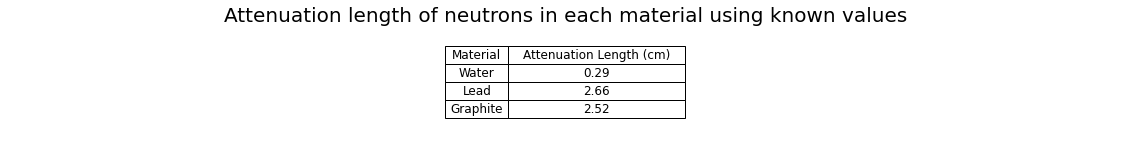

In [7]:
def calculate_attenuation(sigma_a, sigma_s, den, molar_mass):
    """
    Calculates the attenuation length based on the given parameters.

    Args:
    - sigma_a (float): Absorption cross-section.
    - sigma_s (float): Scattering cross-section.
    - den (float): Density of the material.
    - molar_mass (float): Molar mass of the material.

    Returns:
    - float: The attenuation length of the neutron travelling through a medium.
    """
    
    # calculates the mean free path
    return 1/(((AVOGADRO*den)/molar_mass) * (sigma_a + sigma_s))

WATER_ATT_LENGTH = calculate_attenuation(ABS_CROSS_WATER, SCAT_CROSS_WATER, DENSITY_WATER, MOLAR_MASS_WATER)
LEAD_ATT_LENGTH = calculate_attenuation(ABS_CROSS_LEAD, SCAT_CROSS_LEAD, DENSITY_LEAD, MOLAR_MASS_LEAD)
GRAPHITE_ATT_LENGTH = calculate_attenuation(ABS_CROSS_GRAPHITE, SCAT_CROSS_GRAPHITE, DENSITY_GRAPHITE, MOLAR_MASS_GRAPHITE)

# Create a new figure for the table
figure_5, axis_5 = plt.subplots(figsize=(20, 2))

# Create a table for all sets of results
data_5 = [
    ["Water", f"{WATER_ATT_LENGTH:.2f}"],
    ["Lead", f"{LEAD_ATT_LENGTH:.2f}"],
    ["Graphite", f"{GRAPHITE_ATT_LENGTH:.2f}"]
]

columns = ("Material", "Attenuation Length (cm)")

# Hide plot frame
axis_5.axis('tight')
axis_5.axis('off')

# Add the table
table_5 = axis_5.table(cellText=data_5, colLabels=columns, cellLoc = 'center', loc='center')
table_5.set_fontsize(12)

# Auto-adjust column widths
table_5.auto_set_column_width(col=list(range(len(columns))))

axis_5.set_title("Attenuation length of neutrons in each material using known values", fontsize=20)
table_5.scale(1, 1.5)

plt.show()

Water has the shortest attenuation length due to its large scattering cross section. This suggests that more thermal neutrons will travel further in lead and graphite than in water.

## Isotropic vectors

The function `inverse_exp_cdf` calculates the inverse cumulative distribution function (CDF) of an exponential distribution, which is used to generate exponentially distributed random variables (representing step lengths) from uniformly distributed random variables. 

The function `iso_vectors` generates the isotropic vectors, with their lengths defined by the aforementioned exponential distribution. It uses the `inverse_exp_cdf` function to generate step lengths, and another function `generate_vectors` to generate the vector components (x, y, and z) for a given number of steps. 

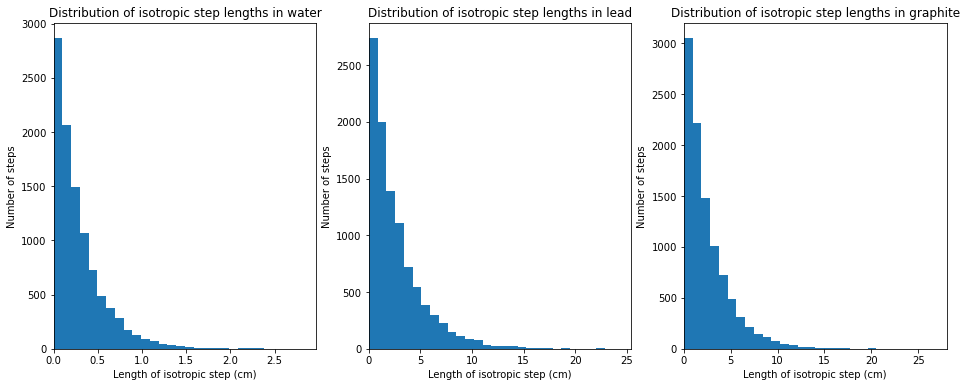

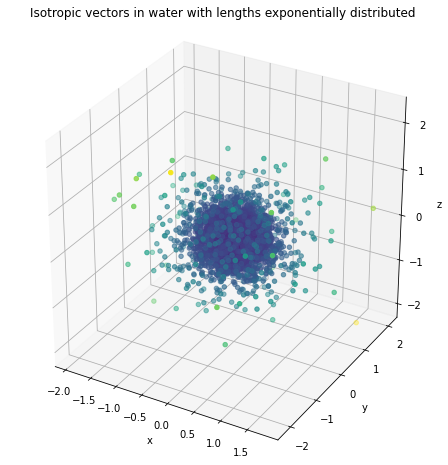

In [8]:
def inverse_exp_cdf(random_number, att_length):
    """
    Calculates the inverse cumulative distribution function (CDF) of the exponential function.

    Args:
    - random_number (float): A random number between 0 and 1, typically generated using a uniform distribution.
    - att_length (float): The attenuation length of the neutron travelling through a medium.

    Returns:
    - float: The value corresponding to the inverse CDF of the exponential function.
    """
    return -att_length * np.log(random_number)

def iso_vectors(attenuation_length, number_steps):
    """
    Generate isotropic vectors for a given number of steps, with exponentially distributed step lengths.

    Args:
    - attenuation_length (float): The attenuation length of the neutron travelling through a medium.
    - number_steps (int): Number of steps or vectors to generate.

    Returns:
    - tuple: A tuple containing three arrays representing the x, y, and z components of the generated isotropic vectors.
    """
    # Lengths exponentially distributed
    step_lengths = inverse_exp_cdf(uni(0,1,number_steps), attenuation_length)
    
    # Isotropic vectors
    x_steps, y_steps, z_steps = generate_vectors(number_steps, step_lengths)

    return x_steps, y_steps, z_steps

WATER_STEPS = iso_vectors(WATER_ATT_LENGTH, N_PARTICLES)
LEAD_STEPS = iso_vectors(LEAD_ATT_LENGTH, N_PARTICLES)
GRAPHITE_STEPS = iso_vectors(GRAPHITE_ATT_LENGTH, N_PARTICLES)

W_STEP_SIZES = np.sqrt(WATER_STEPS[0]**2 + WATER_STEPS[1]**2 + WATER_STEPS[2]**2)
L_STEP_SIZES = np.sqrt(LEAD_STEPS[0]**2 + LEAD_STEPS[1]**2 + LEAD_STEPS[2]**2)
G_STEP_SIZES = np.sqrt(GRAPHITE_STEPS[0]**2 + GRAPHITE_STEPS[1]**2 + GRAPHITE_STEPS[2]**2)

W_STEP_SIZES = np.delete(W_STEP_SIZES, np.argwhere(W_STEP_SIZES==0))
L_STEP_SIZES = np.delete(L_STEP_SIZES, np.argwhere(L_STEP_SIZES==0))
G_STEP_SIZES = np.delete(G_STEP_SIZES, np.argwhere(G_STEP_SIZES==0))

fig_6, axis_6 = plt.subplots(1,3, figsize=(16,6))

axis_6[0].hist(W_STEP_SIZES, bins=BINS, density=False)
axis_6[0].set_xlabel('Length of isotropic step (cm)')
axis_6[0].set_ylabel('Number of steps')
axis_6[0].set_title('Distribution of isotropic step lengths in water')
axis_6[0].set_xlim([0, max(W_STEP_SIZES)])

axis_6[1].hist(L_STEP_SIZES, bins=BINS, density=False)
axis_6[1].set_xlabel('Length of isotropic step (cm)')
axis_6[1].set_ylabel('Number of steps')
axis_6[1].set_title('Distribution of isotropic step lengths in lead')
axis_6[1].set_xlim([0, max(L_STEP_SIZES)])

axis_6[2].hist(G_STEP_SIZES, bins=BINS, density=False)
axis_6[2].set_xlabel('Length of isotropic step (cm)')
axis_6[2].set_ylabel('Number of steps')
axis_6[2].set_title('Distribution of isotropic step lengths in graphite')
axis_6[2].set_xlim([0, max(G_STEP_SIZES)])

plt.subplots_adjust(hspace=0.2)  # Adjust the space between plots
plt.show()

fig_7 = plt.figure(figsize=(8,6))
axis_7 = Axes3D(fig_7)
axis_7.scatter(WATER_STEPS[0], WATER_STEPS[1], WATER_STEPS[2], 
           c=np.linalg.norm((WATER_STEPS[0], WATER_STEPS[1], WATER_STEPS[2]), axis=0))
axis_7.set_xlabel('x')
axis_7.set_ylabel('y')
axis_7.set_zlabel('z')
axis_7.set_box_aspect(aspect = (1,1,1))
axis_7.set_title("Isotropic vectors in water with lengths exponentially distributed")
plt.show()



The histograms display the distribution of isotropic step lengths in each of the three media. As the histograms show the step lengths are exponentially distributed. The disribution of step lengths in water are much shorter than in lead and graphite; this is due to water having a shorter attenuation length.


The 3D scatter plot shows the isotropic vectors in the water medium with the step lengths exponentially distributed. As shown in the plot, there is a concentration of points in the centre of the sphere which means the neutron has a higher probability of taking a shorter step than longer step. The points are approximately uniformly distributed in all directions representing the neutrons random motion.

# 6) Simulating random walks of neutrons as they travel through water, lead, and graphite

Using the functions built, this section will simulate the behavior of neutrons as they traverse through three different materials water, lead, and graphite.

The first task involves using the macroscopic absorption and scattering cross-sections to determine the probability of a neutron being absorbed using the equation $$P_a=\frac{Σ_a}{Σ_a + Σ_s}$$ where if a random number $u$ is less than $P_a$ then the neutron is absorbed by the material and if it is greater the neutron is scattered.

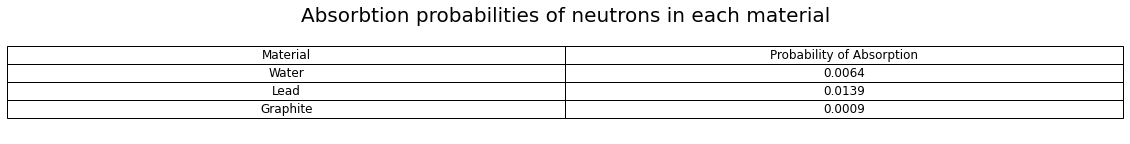

In [9]:
def probability_abs(sigma_1, sigma_2, density, mass):
    """
    Calculate the probability of absorption for a given material and length.

    Args:
    - sigma_1 (float): Absorption cross-section for the material.
    - sigma_2 (float): Scattering cross-section for the material.
    - density (float): Density of the material.
    - mass (float): Molar mass of the material.

    Returns:
    - float: The probability of absorption.
    """
    cross_a = (((AVOGADRO)*density)/mass) * sigma_1
    cross_s = (((AVOGADRO)*density)/mass) * sigma_2
    prob_a = cross_a / (cross_a + cross_s)
    return prob_a

PROB_ABS_WATER = probability_abs(ABS_CROSS_WATER, SCAT_CROSS_WATER, DENSITY_WATER, MOLAR_MASS_WATER)
PROB_ABS_LEAD = probability_abs(ABS_CROSS_LEAD, SCAT_CROSS_LEAD, DENSITY_LEAD, MOLAR_MASS_LEAD)
PROB_ABS_GRAPHITE = probability_abs(ABS_CROSS_GRAPHITE, SCAT_CROSS_GRAPHITE, DENSITY_GRAPHITE, MOLAR_MASS_GRAPHITE)

# Data to display table
data_abs = [["Water", "{:.4f}".format(PROB_ABS_WATER)],
        ["Lead", "{:.4f}".format(PROB_ABS_LEAD)],
        ["Graphite", "{:.4f}".format(PROB_ABS_GRAPHITE)]]

# Create a new figure
fig_8, ax_8 = plt.subplots(1, 1, figsize=(20,2))

# Hide axes
ax_8.axis('tight')
ax_8.axis('off')

# Create table
table_8 = ax_8.table(cellText=data_abs,
                 colLabels=["Material", "Probability of Absorption"],
                 cellLoc = 'center', 
                 loc='center')

# Auto scale
table_8.auto_set_font_size(False)
table_8.set_fontsize(12)
table_8.scale(1, 1.5)
ax_8.set_title("Absorbtion probabilities of neutrons in each material", fontsize=20)

plt.show()

This shows that lead has the highest probability of a neutron being absorbed and graphite has the least. All three materials show that a thermal neutron is much more likely to be scattered than absorbed in an interaction. 

This agrees with theory as thermal neutrons are more likely to be scattered than absorbed because of their low energy. When a thermal neutron collides with an atomic nucleus, it is more likely to bounce off (scatter) than to be captured by the nucleus (absorbed).

## Visualise the walk

Next, the program will visualize the random walk of a neutron through each material. The simulation should consider a slab of thickness 10 cm. Each neutron enters the slab perpendicularly from the left side and then performs a random walk according to the distribution $exp(-x/λ)$, where x is the neutron's position at each step. The simulation must check at each step whether the neutron is absorbed, scattered within the slab, or has escaped from it. The random walk continues only if the neutron is scattered inside the slab.

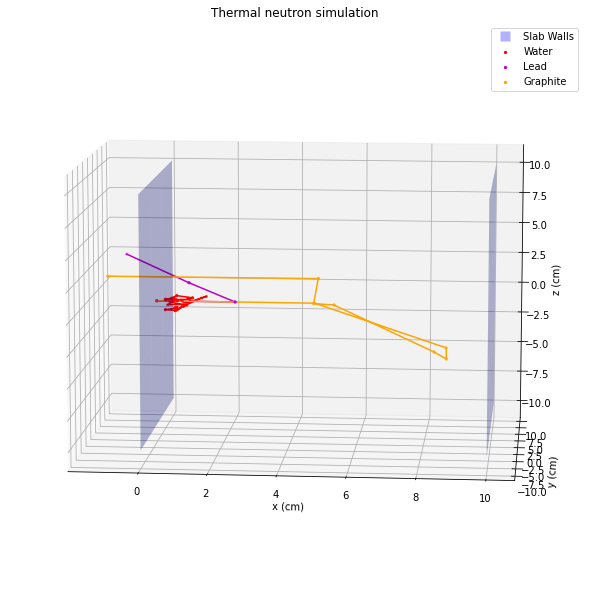

In [10]:
def visual_walk(p_a, attenuation_length, thick):
    """
    Simulate a visual walk of a neutron through a material.

    Args:
    - p_a (float): Probability of absorption for the material.
    - attenuation_length (float): The attenuation length of the neutron travelling through a medium.
    - thick (float): Thickness of the material.

    Returns:
    - tuple: A tuple containing three arrays representing the x, y, and z coordinates of the neutron's position.
    """
    # Maximum number of steps
    max_steps = 1000
    
    # Coordinates of the neutron
    x_pos = np.zeros(max_steps)
    y_pos = np.zeros(max_steps)
    z_pos = np.zeros(max_steps)
        
    # First step only has x component
    first_step = iso_vectors(attenuation_length, 1)
    
    first_move = abs(-attenuation_length*np.log(np.random.uniform()))
    x_pos[1] = first_move
    step = 1
    
    is_running = True
    while (is_running):
        if (x_pos[step] < 0):
            return x_pos[:step + 1], y_pos[:step + 1], z_pos[:step + 1]
        elif (x_pos[step] > thick):
            return x_pos[:step + 1], y_pos[:step + 1], z_pos[:step + 1]
        elif (uni(0, 1) < p_a):
            return x_pos[:step + 1], y_pos[:step + 1], z_pos[:step + 1]
        
        # Neutron step
        scatter_step = iso_vectors(attenuation_length, 1)
        
        # Calculate next position of neutron
        step += 1
        x_pos[step] = x_pos[step - 1] + scatter_step[0]
        y_pos[step] = y_pos[step - 1] + scatter_step[1]
        z_pos[step] = z_pos[step - 1] + scatter_step[2]
        
def display_random_walk(walk_1, walk_2, walk_3, fig, thick):   
    """
    Display the random walks of particles in a 3D plot.

    Args:
    - walk_1 (tuple): Tuple containing three arrays representing the x, y, and z coordinates of the first walk.
    - walk_2 (tuple): Tuple containing three arrays representing the x, y, and z coordinates of the second walk.
    - walk_3 (tuple): Tuple containing three arrays representing the x, y, and z coordinates of the third walk.
    - fig (int): Figure number for the plot.
    - thick (float): Thickness of the slab walls.

    Returns:
    - None
    """
    Y = np.linspace(-10, 10, 4)
    Z = np.linspace(-10, 10, 4)

    Y, Z = np.meshgrid(Y, Z)  # Create a grid of Y and Z values
    X_0 = np.zeros_like(Y)    # Create a matrix of zeros with the same shape as Y
    X_thick = np.full_like(Y, thick)  # Create a matrix of 10s with the same shape as Y

    fig_walk = plt.figure(fig, figsize=(10,8))
    axis_random = Axes3D(fig_walk)
    
    axis_random.scatter(walk_1[0], walk_1[1], walk_1[2], color='r', marker='.', label='Water')
    axis_random.plot(walk_1[0], walk_1[1], walk_1[2], color='r', linestyle='-')
    
    axis_random.scatter(walk_2[0], walk_2[1], walk_2[2], color='m', marker='.', label='Lead')
    axis_random.plot(walk_2[0], walk_2[1], walk_2[2], color='m', linestyle='-')
    
    axis_random.scatter(walk_3[0], walk_3[1], walk_3[2], color='orange', marker='.', label='Graphite')
    axis_random.plot(walk_3[0], walk_3[1], walk_3[2], color='orange', linestyle='-')
    
    axis_random.set_xlabel('x (cm)')
    axis_random.set_ylabel('y (cm)')
    axis_random.set_zlabel('z (cm)')

    axis_random.plot_surface(X_0, Y, Z, alpha=0.3, color='b')
    axis_random.plot_surface(X_thick, Y, Z, alpha=0.3, color='b')
    axis_random.set_title('Thermal neutron simulation')


    # Create a proxy artist for the legend
    proxy_surface = plt.Line2D([0], [0], linestyle='none', mfc='b',
                               alpha=0.3, mec='none', marker='s', markersize=10)
    plt.legend()
    axis_random.legend(handles=[proxy_surface] + axis_random.collections, labels=['Slab Walls', 'Water', 'Lead', 'Graphite'])
    axis_random.set_box_aspect(aspect = (1.5,1,1))
    axis_random.view_init(elev=10, azim=-85)

    
WATER_VISUAL_WALK = visual_walk(PROB_ABS_WATER, WATER_ATT_LENGTH, 10)
LEAD_VISUAL_WALK = visual_walk(PROB_ABS_LEAD, LEAD_ATT_LENGTH, 10)
GRAPHITE_VISUAL_WALK = visual_walk(PROB_ABS_GRAPHITE, GRAPHITE_ATT_LENGTH, 10)

display_random_walk(WATER_VISUAL_WALK, LEAD_VISUAL_WALK, GRAPHITE_VISUAL_WALK, 9, 10)

A particle history is the path taken by a particle until it stops (is absorbed). At each step, the particle can either scatter and continue moving or be absorbed and stop. However if the particle leaves the slab, the simulation ignores further calculations for theses particles. This is called ‘killing’ the particle history. The direction of each step is isotropic, but the distance traveled follows an exponential distribution with parameter λ (attenuation length). This process is an example of a Markov Chain Monte Carlo method.

# 7) Simulating 100000 particles

In this part of the project, the focus shifts from individual neutron paths to the broader statistical properties of the neutron population as a whole. The simulation will calculate 10000 neutrons paths and determine the number of neutrons absorbed, reflected, and transmitted, thus providing a numerical estimation of the corresponding rates. For this analysis, a slab thickness of 10 cm is considered.

A crucial aspect of this study is quantifying the uncertainty associated with each of these rates. Any real-world experiment or simulation carries an inherent degree of uncertainty, and acknowledging this uncertainty is a cornerstone of rigorous scientific methodology. By incorporating the calculation of uncertainties in the results, a more complete and reliable report of the findings can be provided.

In [11]:
def random_walk(thick, sample, p_a, attenuation_length, repeats):
    """
    Simulate random walks of particles through a material and calculate statistics of reflection, absorption, and transmission.

    Args:
    - thick (float): Thickness of the material.
    - sample (int): Number of particles or samples to simulate.
    - p_a (float): Probability of absorption for the material.
    - attenuation_length (float): Attenuation length, representing the mean free path of particles.
    - repeats (int): Number of times to repeat the simulation.

    Returns:
    - tuple: A tuple containing the following elements:
        - mean_reflected (float): Mean number of particles reflected.
        - mean_absorbed (float): Mean number of particles absorbed.
        - mean_transmitted (float): Mean number of particles transmitted.
        - std_reflected (float): Standard deviation of the number of particles reflected.
        - std_absorbed (float): Standard deviation of the number of particles absorbed.
        - std_transmitted (float): Standard deviation of the number of particles transmitted.
    """
    
    mean_reflected = np.zeros(repeats)
    mean_transmitted = np.zeros(repeats)
    mean_absorbed = np.zeros(repeats)
    
    for i in range(repeats):
        n_reflected = 0
        n_transmitted = 0
        n_absorbed = 0
        
        # Coordinates of the neutron
        x_pos = np.zeros(sample)


        # First step only has x component    
        first_move = abs(-attenuation_length*np.log(np.random.uniform(0,1,sample)))
        x_pos += first_move


        while (len(x_pos)>0):
            n_reflected += np.count_nonzero(x_pos<0)
            x_pos = np.delete(x_pos, np.argwhere(x_pos<0))

            n_transmitted += np.count_nonzero(x_pos>thick)
            x_pos = np.delete(x_pos, np.argwhere(x_pos>thick))

            random_numbers = uni(0,1, len(x_pos))
            n_absorbed += np.count_nonzero(random_numbers < p_a)
            x_pos = np.delete(x_pos, np.argwhere(np.argwhere(random_numbers < p_a)))

            # Neutron step
            scatter_step = iso_vectors(attenuation_length, len(x_pos))
            x_pos += scatter_step[0]
   
        mean_reflected[i] = n_reflected
        mean_transmitted[i] = n_transmitted
        mean_absorbed[i] = n_absorbed      
        
    std_reflected = np.std(mean_reflected)
    std_transmitted = np.std(mean_transmitted)
    std_absorbed = np.std(mean_absorbed)
    
    mean_reflected = np.mean(mean_reflected)
    mean_transmitted = np.mean(mean_transmitted)
    mean_absorbed = np.mean(mean_absorbed)

    return mean_reflected, mean_absorbed, mean_transmitted, std_reflected, std_absorbed, std_transmitted 

The `random_walk` function simulates the behavior of particles as they traverse a material, specifically tracking how many particles are reflected, absorbed, and transmitted through the material. It takes as input the thickness of the material, the number of particles to simulate, the probability of absorption for the material, the attenuation length, and the number of times to repeat the simulation.

The function initializes counters and arrays to keep track of the outcomes for each simulation repeat. It then begins a loop for each simulation repeat. In each loop, the function simulates the random walk of each particle, updating its position and checking whether it is reflected, transmitted, or absorbed. The random walk continues until no particles remain unaccounted for.

The function finally calculates and returns the mean and standard deviation of the numbers of reflected, absorbed, and transmitted particles across all simulation repeats. The standard deviation is used to estimate the uncertainty in each measurement.

The choice of 10000 particles and 10 iterations is a balance between computational efficiency and statistical robustness. By using a large number of particles, the simulation can capture the probabilistic nature of the particle-material interactions. Repeating the simulation multiple times helps to average out any statistical anomalies that might occur in a single run, giving a more reliable estimate of the mean behavior and associated uncertainty. However, increasing these numbers further would increase the computational load, so a balance must be struck between accuracy and efficiency.

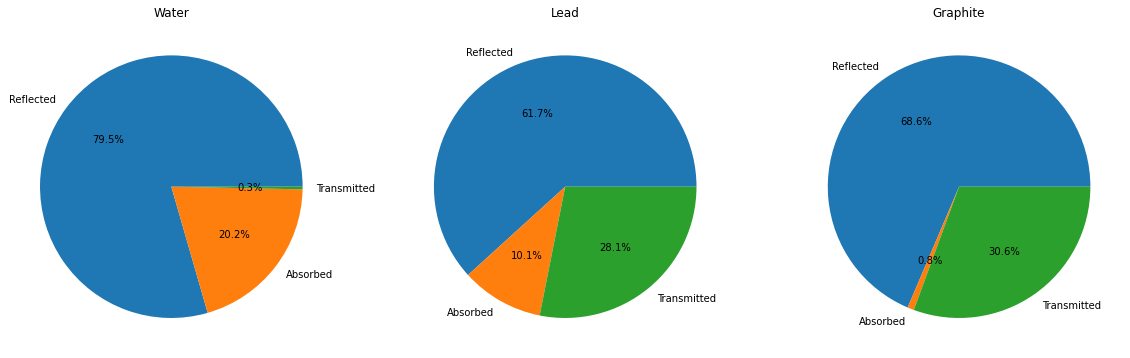

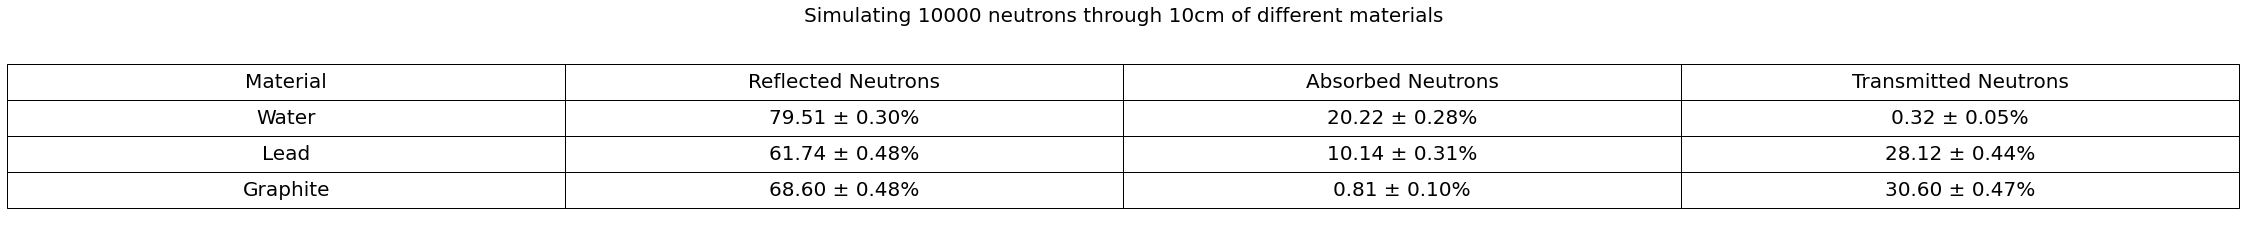

In [12]:
def pie(r,a,t):
    """
    Generate a pie chart visualizing the distribution of reflected, absorbed, and transmitted values.

    Args:
    - r (float): Value representing the reflected component.
    - a (float): Value representing the absorbed component.
    - t (float): Value representing the transmitted component.

    Returns:
    - tuple: A tuple containing the following elements:
        - y (array): Array of values representing the distribution of reflected, absorbed, and transmitted.
        - mylabels (list): List of labels for the pie chart.
    """
    
    total = (r+a+t) / 100
    y = np.array([r,a,t])
    mylabels = ["Reflected", "Absorbed", "Transmitted"]
    return y, mylabels

WATER_WALK = random_walk(10, N_PARTICLES, PROB_ABS_WATER, WATER_ATT_LENGTH, ITERATIONS)
LEAD_WALK = random_walk(10, N_PARTICLES, PROB_ABS_LEAD, LEAD_ATT_LENGTH, ITERATIONS)
GRAPHITE_WALK = random_walk(10, N_PARTICLES, PROB_ABS_GRAPHITE, GRAPHITE_ATT_LENGTH, ITERATIONS)

WATER_PIE = pie(WATER_WALK[0], WATER_WALK[1], WATER_WALK[2])
LEAD_PIE = pie(LEAD_WALK[0], LEAD_WALK[1], LEAD_WALK[2])
GRAPHITE_PIE =pie(GRAPHITE_WALK[0], GRAPHITE_WALK[1], GRAPHITE_WALK[2])

fig_10, axis_10 = plt.subplots(1,3, figsize=(20,20))  # create a single row with three plots

# now axis_11 is an array of axes, we can use them to plot

axis_10[0].pie(WATER_PIE[0], labels=WATER_PIE[1], autopct='%1.1f%%')
axis_10[0].set_title('Water')

axis_10[1].pie(LEAD_PIE[0], labels=LEAD_PIE[1], autopct='%1.1f%%')
axis_10[1].set_title('Lead')

axis_10[2].pie(GRAPHITE_PIE[0], labels=GRAPHITE_PIE[1], autopct='%1.1f%%')
axis_10[2].set_title('Graphite')

plt.show()

# Create a new figure for the table
fig_11, axis_11 = plt.subplots(figsize=(20, 4))

# Create a table for all sets of results
data_11 = [
    ["Water", f"{WATER_WALK[0]/ N_PARTICLES * 100:.2f} ± {WATER_WALK[3]/ N_PARTICLES * 100:.2f}%", f"{WATER_WALK[1]/ N_PARTICLES * 100:.2f} ± {WATER_WALK[4]/ N_PARTICLES * 100:.2f}%", f"{WATER_WALK[2]/ N_PARTICLES * 100:.2f} ± {WATER_WALK[5]/ N_PARTICLES * 100:.2f}%"],
    ["Lead", f"{LEAD_WALK[0]/ N_PARTICLES * 100:.2f} ± {LEAD_WALK[3]/ N_PARTICLES * 100:.2f}%", f"{LEAD_WALK[1]/ N_PARTICLES * 100:.2f} ± {LEAD_WALK[4]/ N_PARTICLES * 100:.2f}%", f"{LEAD_WALK[2]/ N_PARTICLES * 100:.2f} ± {LEAD_WALK[5]/ N_PARTICLES * 100:.2f}%"],
    ["Graphite", f"{GRAPHITE_WALK[0]/ N_PARTICLES * 100:.2f} ± {GRAPHITE_WALK[3]/ N_PARTICLES * 100:.2f}%", f"{GRAPHITE_WALK[1]/ N_PARTICLES * 100:.2f} ± {GRAPHITE_WALK[4]/ N_PARTICLES * 100:.2f}%", f"{GRAPHITE_WALK[2]/ N_PARTICLES * 100:.2f} ± {GRAPHITE_WALK[5]/ N_PARTICLES * 100:.2f}%"]
]

columns_11 = ("Material", "Reflected Neutrons", "Absorbed Neutrons", "Transmitted Neutrons")

# Hide plot frame
axis_11.axis('tight')
axis_11.axis('off')

# Add the table
table_11 = axis_11.table(cellText=data_11, colLabels=columns_11, cellLoc = 'center', loc='center')
table_11.set_fontsize(20)

# Auto-adjust column widths
table_11.scale(2, 3)
axis_11.set_title("Simulating 10000 neutrons through 10cm of different materials", fontsize=20)

plt.show()

Water has the highest percentage of neutrons reflected back out of the slab, this is due to it having a much larger scattering cross section than lead and graphite. Water also had the highest percentage of absorbed neutrons which means it has the lowest amount of transmitted neutrons; this corresponds to water having the shortest attenuation length out of the three materials. This means on average more neutrons will travel further in lead and graphite. Lead and graphite have similar amounts of transmitted neutrons however neutrons in lead have a higher chance of being absorbed than graphite. This is due to graphite having a much smaller absorption cross section than lead.

# 8) Varying thickness

The subsequent phase of the project involves a comparative study of three materials - water, lead, and graphite - by examining the variations in their neutron interaction rates with respect to slab thickness. The variation in neutron transmission, reflection, and absorption rates is plotted against the thickness of the material slab. The transmission rates of the neutrons in each material can be used to determine the characteristic attenuation lengths and their estimated errors for the three materials. 

In [13]:
def varying_thickness(max_thick, sample, p_a, attenuation_length, repeats):
    """
    Simulate random walks for varying thicknesses of a material and calculate ratios and uncertainties.

    Args:
    - max_thick (int): Maximum thickness of the material to simulate.
    - sample (int): Number of particles or samples to simulate.
    - p_a (float): Probability of absorption for the material.
    - attenuation_length (float): Attenuation length, representing the mean free path of particles.
    - repeats (int): Number of times to repeat the simulation.

    Returns:
    - tuple: A tuple containing the following elements:
        - ref_ratio (array): Array of ratios of reflected neutrons for each thickness.
        - abs_ratio (array): Array of ratios of absorbed neutrons for each thickness.
        - tran_ratio (array): Array of ratios of transmitted neutrons for each thickness.
        - ref_un (array): Array of uncertainties of the reflected neutron ratios.
        - abs_un (array): Array of uncertainties of the absorbed neutron ratios.
        - tran_un (array): Array of uncertainties of the transmitted neutron ratios.
        - thick (array): Array of thickness values.
    """
    abs_ratio = np.zeros(max_thick)
    tran_ratio = np.zeros(max_thick)
    ref_ratio = np.zeros(max_thick)
    
    abs_un = np.zeros(max_thick)
    tran_un = np.zeros(max_thick)
    ref_un = np.zeros(max_thick)
    
    i=0
    for T in tnrange(1,max_thick+1,desc="Progress"):
        results = random_walk(T, sample, p_a, attenuation_length, repeats)
        
        ref_ratio[i] = results[0]
        abs_ratio[i] = results[1]
        tran_ratio[i] = results[2]
        
        ref_un[i] = results[3]
        abs_un[i] = results[4]
        tran_un[i] = results[5]

        i+=1
        
    thick = np.arange(1, max_thick+1)
        
    return ref_ratio, abs_ratio, tran_ratio, ref_un, abs_un, tran_un, thick

## Water

In [ ]:
WATER_VARY_T = varying_thickness(MAXIMUM_THICKNESS, N_PARTICLES, PROB_ABS_WATER, WATER_ATT_LENGTH, ITERATIONS)

figure_12, axis_12 = plt.subplots(1, 3, figsize=(15, 5))

axis_12[0].errorbar(WATER_VARY_T[6], WATER_VARY_T[0]/N_PARTICLES*100, yerr=WATER_VARY_T[3]/N_PARTICLES*100, fmt='.-', label="Reflected")
axis_12[0].set_xlabel('Thickness (cm)')
axis_12[0].set_ylabel('Percentage of total neutrons')
axis_12[0].set_title('Percentages of neutrons in water: reflected')
axis_12[0].set_xticks(range(1,22,2))


axis_12[1].errorbar(WATER_VARY_T[6], WATER_VARY_T[1]/N_PARTICLES*100, yerr=WATER_VARY_T[4]/N_PARTICLES*100, fmt='.-', label="Absorbed")
axis_12[1].set_xlabel('Thickness (cm)')
axis_12[1].set_ylabel('Percentage of total neutrons')
axis_12[1].set_title('Percentages of neutrons in water: absorbed')
axis_12[1].set_xticks(range(1,22,2))


axis_12[2].errorbar(WATER_VARY_T[6], WATER_VARY_T[2]/N_PARTICLES*100, yerr=WATER_VARY_T[5]/N_PARTICLES*100, fmt='.-', label="Transmitted")
axis_12[2].set_xlabel('Thickness (cm)')
axis_12[2].set_ylabel('Percentage of total neutrons')
axis_12[2].set_title('Percentages of neutrons in water: transmitted')
axis_12[2].set_xticks(range(1,22,2))


plt.tight_layout()
plt.xticks(range(1,10))
plt.show()


The number of reflected neutrons in water rapidly increases with thickness then plateaus around 5 cm at a constant rate of around 78 percent. Absorbed neutrons also follow a similar pattern; they increase at a high rate until around 5 cm then plateu around 20 percent. In contrast the number of transmitted neutrons quickly drops from around 30 percent intially to 0 around 10 cm.

The graphs show that as the thickness increases the uncertanity increases for reflected neutrons and absorbed neutrons, however because the transmitted neutrons drop to 0 percent the uncertainity is also very small.

## Lead

In [ ]:
LEAD_VARY_T = varying_thickness(MAXIMUM_THICKNESS, N_PARTICLES, PROB_ABS_LEAD, LEAD_ATT_LENGTH, ITERATIONS)

figure_13, axis_13 = plt.subplots(1, 3, figsize=(15, 5))

axis_13[0].errorbar(LEAD_VARY_T[6], LEAD_VARY_T[0]/N_PARTICLES*100, yerr=LEAD_VARY_T[3]/N_PARTICLES*100, fmt='.-', label="Reflected")
axis_13[0].set_xlabel('Thickness (cm)')
axis_13[0].set_ylabel('Percentage of total neutrons')
axis_13[0].set_title('Percentages of neutrons in lead: reflected')
axis_13[0].set_xticks(range(1,22, 2))


axis_13[1].errorbar(LEAD_VARY_T[6], LEAD_VARY_T[1]/N_PARTICLES*100, yerr=LEAD_VARY_T[4]/N_PARTICLES*100, fmt='.-', label="Absorbed")
axis_13[1].set_xlabel('Thickness (cm)')
axis_13[1].set_ylabel('Percentage of total neutrons')
axis_13[1].set_title('Percentages of neutrons in lead: absorbed')
axis_13[1].set_xticks(range(1,22, 2))


axis_13[2].errorbar(LEAD_VARY_T[6], LEAD_VARY_T[2]/N_PARTICLES*100, yerr=LEAD_VARY_T[5]/N_PARTICLES*100, fmt='.-', label="Transmitted")
axis_13[2].set_xlabel('Thickness (cm)')
axis_13[2].set_ylabel('Percentage of total neutrons')
axis_13[2].set_title('Percentages of neutrons in lead: transmitted')
axis_13[2].set_xticks(range(1,22, 2))

plt.tight_layout()
plt.show()

The number of reflected neutrons in lead follows a similar pattern to water but with a more shallow inital gradient and plateus at a slower rate. The biggest difference between the neutrons in water and lead is the number of absorbed neutrons. In lead the number of absorbed neutrons appears to follow linear relation with thickness. The number of transmitted neutrons also differs from water; in lead the rate of decrease of neutrons transmitted is much slower than in water and do not drop to 0 percent at any point between 1 cm and 20 cm.  

## Graphite

In [ ]:
GRAPHITE_VARY_T = varying_thickness(MAXIMUM_THICKNESS, N_PARTICLES, PROB_ABS_GRAPHITE, GRAPHITE_ATT_LENGTH, ITERATIONS)

figure_14, axis_14 = plt.subplots(1, 3, figsize=(15, 5))

axis_14[0].errorbar(GRAPHITE_VARY_T[6], GRAPHITE_VARY_T[0]/N_PARTICLES*100, yerr=GRAPHITE_VARY_T[3]/N_PARTICLES*100, fmt='.-', label="Reflected")
axis_14[0].set_xlabel('Thickness (cm)')
axis_14[0].set_ylabel('Percentage of total neutrons')
axis_14[0].set_title('Percentages of neutrons in graphite: reflected')
axis_14[0].set_xticks(range(1,22,2))


axis_14[1].errorbar(GRAPHITE_VARY_T[6], GRAPHITE_VARY_T[1]/N_PARTICLES*100, yerr=GRAPHITE_VARY_T[4]/N_PARTICLES*100, fmt='.-', label="Absorbed")
axis_14[1].set_xlabel('Thickness (cm)')
axis_14[1].set_ylabel('Percentage of total neutrons')
axis_14[1].set_title('Percentages of neutrons in graphite: absorbed')
axis_14[1].set_xticks(range(1,22,2))


axis_14[2].errorbar(GRAPHITE_VARY_T[6], GRAPHITE_VARY_T[2]/N_PARTICLES*100, yerr=GRAPHITE_VARY_T[5]/N_PARTICLES*100, fmt='.-', label="Transmitted")
axis_14[2].set_xlabel('Thickness (cm)')
axis_14[2].set_ylabel('Percentage of total neutrons')
axis_14[2].set_title('Percentages of neutrons in graphite: transmitted')
axis_14[2].set_xticks(range(1,22,2))

plt.tight_layout()
plt.show()


Graphite shows very similar patterns to lead. The main difference is the larger errorbars in the neutrons absorbed. This is due to the number of absorbed neutrons in graphite being much smaller than in lead so the random fluctuations between iterations seems larger relative to the smaller absorption rates of graphite than in lead. 

# 9) Determine the characteristic attenuation lengths

In this phase of the project, the aim is to determine the characteristic attenuation lengths for the three materials - water, lead, and graphite - based on their transmission rates. The characteristic attenuation length represents the average distance a neutron can travel through a material before its intensity is significantly reduced.

Calculation of the characteristic attenuation length will utilize the transmission rates obtained in the previous analysis. Analysis of the relationship between the thickness of the material slab and the corresponding transmission rates can extract valuable information about how effectively each material attenuates neutron flux.

In [ ]:
def linear_fit(thickness, per_neutrons, errors):
    """
    Perform a linear fit on the data points and calculate the gradient, intercept, and associated uncertainties.

    Args:
    - thickness (array): Array of thickness values.
    - per_neutrons (array): Array of neutron percentages corresponding to each thickness.
    - errors (array): Array of errors associated with the neutron percentages.

    Returns:
    - tuple: A tuple containing the following elements:
        - gradient (float): Gradient of the linear fit.
        - intercept (float): Intercept of the linear fit.
        - gradient_err (float): Uncertainty of the gradient.
        - intercept_err (float): Uncertainty of the intercept.
        - empty (array): Array of indices corresponding to data points with zero neutron percentages.
    """
    
    empty = np.argwhere(per_neutrons == 0)
    thickness = np.delete(thickness, empty)
    per_neutrons = np.delete(per_neutrons, empty)
    errors = np.delete(errors, empty)
        
    weight = per_neutrons / errors
    
    coefficients, covariance  = np.polyfit(thickness, np.log(per_neutrons), w=weight, deg=1,cov=True)
    gradient, inter = coefficients
    gradient_err, inter_err = np.sqrt(np.diag(covariance))
    
    return gradient, inter, gradient_err, inter_err, empty

def chi_reduced(obs, x, m, c, un):
    """
    Calculate the reduced chi-square value for a linear regression model.

    Args:
    - obs (array): Array of observed values.
    - x (array): Array of independent variable values.
    - m (float): Slope of the linear regression model.
    - c (float): Intercept of the linear regression model.
    - un (array): Array of uncertainties associated with the observed values.

    Returns:
    - float: The reduced chi-square value.
    """
    
    chi_square = np.sum(((obs - (m*x+c))/ un)**2)
    chi_reduced = chi_square / (len(x)-2)
    return chi_reduced

The `linear_fit` function performs a weighted linear fit on the given data points (thickness and neutron percentages) and calculates the slope (gradient), intercept, and their associated uncertainties. The weight of each data point is calculated as the ratio of the mean neutron percentage transmitted to its standard deviation. The uncertainties on the gradient and intercept are calculated from the covariance of the fit parameters.


The `chi_square` function calculates the reduced chi-square statistic for a linear regression model. The reduced chi-square is a measure of the goodness of fit of the model to the data. It is calculated as the sum of the squared residuals (difference between observed and predicted values), normalized by the variance (square of the uncertainty) and divided by the degrees of freedom (number of data points minus number of parameters).

The chi-square statistic follows a chi-square distribution if the errors are normally distributed. A reduced chi-square close to 1 indicates a good fit, while a value significantly greater than 1 suggests that the model does not fit the data well (or the errors have been underestimated), and a value significantly less than 1 suggests that the errors have been overestimated.

## Error propagation

The error on the mean neutron transmission is taken as the standard deviation $σ_t$. By propagating this error the error on the points in the linear fit can be found. The error $σ_l$ on the data points in the linear fits is $$σ_l = \frac{σ_t}{t}$$ where $t$ is the mean neutron transmission at a certain thickness.

In [ ]:
# Perform np.polyfit and each materials transmission rate
WATER_LIN_FIT = linear_fit(WATER_VARY_T[6], WATER_VARY_T[2], WATER_VARY_T[5])
LEAD_LIN_FIT = linear_fit(LEAD_VARY_T[6], LEAD_VARY_T[2], LEAD_VARY_T[5])
GRAPHITE_LIN_FIT = linear_fit(GRAPHITE_VARY_T[6], GRAPHITE_VARY_T[2], GRAPHITE_VARY_T[5])

# Taking the log of the percenetage of neutrons transmitted in each material
WATER_TRANS = np.log(WATER_VARY_T[2])
LEAD_TRANS = np.log(LEAD_VARY_T[2])
GRAPHITE_TRANS = np.log(GRAPHITE_VARY_T[2])

# Array of the values of thickness for each material
W_THICKNESS = WATER_VARY_T[6]
L_THICKNESS = LEAD_VARY_T[6]
G_THICKNESS = GRAPHITE_VARY_T[6]

# The uncertainty in the linear fit values is the percentage error of the transmission rates
WATER_UN = WATER_VARY_T[5]/WATER_VARY_T[2]
LEAD_UN = LEAD_VARY_T[5]/LEAD_VARY_T[2]
GRAPHITE_UN = GRAPHITE_VARY_T[5]/GRAPHITE_VARY_T[2]

# Delete data points with zero neutron percentages.
WATER_TRANS = np.delete(WATER_TRANS, WATER_LIN_FIT[4])
LEAD_TRANS = np.delete(LEAD_TRANS, LEAD_LIN_FIT[4])
GRAPHITE_TRANS = np.delete(GRAPHITE_TRANS, GRAPHITE_LIN_FIT[4])

W_THICKNESS = np.delete(W_THICKNESS, WATER_LIN_FIT[4])
L_THICKNESS = np.delete(L_THICKNESS, LEAD_LIN_FIT[4])
G_THICKNESS = np.delete(G_THICKNESS, GRAPHITE_LIN_FIT[4])

WATER_UN = np.delete(WATER_UN, WATER_LIN_FIT[4])
LEAD_UN = np.delete(LEAD_UN, LEAD_LIN_FIT[4])
GRAPHITE_UN = np.delete(GRAPHITE_UN, GRAPHITE_LIN_FIT[4])

figure_15, axis_15 = plt.subplots(1, 3, figsize=(18, 6))

# Water
axis_15[0].errorbar(W_THICKNESS, WATER_TRANS, yerr=WATER_UN, fmt='.-', label="Transmitted")
axis_15[0].plot(VARIABLE_THICKNESS, WATER_LIN_FIT[0]*VARIABLE_THICKNESS+WATER_LIN_FIT[1])
axis_15[0].set_xlabel('Thickness (cm)')
axis_15[0].set_ylabel('log(Percentage of total neutrons)')
axis_15[0].set_title('Attenuation length of water')

# Lead
axis_15[1].errorbar(L_THICKNESS, LEAD_TRANS, yerr=LEAD_UN, fmt='.-', label="Transmitted")
axis_15[1].plot(VARIABLE_THICKNESS, LEAD_LIN_FIT[0]*VARIABLE_THICKNESS+LEAD_LIN_FIT[1])
axis_15[1].set_xlabel('Thickness (cm)')
axis_15[1].set_ylabel('log(Percentage of total neutrons)')
axis_15[1].set_title('Attenuation length of lead')

# Graphite
axis_15[2].errorbar(G_THICKNESS, GRAPHITE_TRANS, yerr=GRAPHITE_UN, fmt='.-', label="Transmitted")
axis_15[2].plot(VARIABLE_THICKNESS, GRAPHITE_LIN_FIT[0]*VARIABLE_THICKNESS+GRAPHITE_LIN_FIT[1])
axis_15[2].set_xlabel('Thickness (cm)')
axis_15[2].set_ylabel('log(Percentage of total neutrons)')
axis_15[2].set_title('Attenuation length of graphite')

plt.tight_layout()
plt.show()

# Calculate the characteristic attenuation lengths from the gradient of the linear fit and the corresponding error
FINAL_RESULTS_WATER = -1/WATER_LIN_FIT[0]
ERR_WATER_PATH = abs(FINAL_RESULTS_WATER*(WATER_LIN_FIT[2] / WATER_LIN_FIT[0]))

FINAL_RESULTS_LEAD = -1/LEAD_LIN_FIT[0]
ERR_LEAD_PATH = abs(FINAL_RESULTS_LEAD*(LEAD_LIN_FIT[2] / LEAD_LIN_FIT[0]))

FINAL_RESULTS_GRAPHITE = -1/GRAPHITE_LIN_FIT[0]
ERR_GRAPHITE_PATH = abs(FINAL_RESULTS_GRAPHITE*(GRAPHITE_LIN_FIT[2] / GRAPHITE_LIN_FIT[0]))

CHI_REDUCED_WATER = chi_reduced(WATER_TRANS, W_THICKNESS, WATER_LIN_FIT[0], WATER_LIN_FIT[1], WATER_UN)
CHI_REDUCED_LEAD = chi_reduced(LEAD_TRANS, L_THICKNESS, LEAD_LIN_FIT[0], LEAD_LIN_FIT[1], LEAD_UN)
CHI_REDUCED_GRAPHITE = chi_reduced(GRAPHITE_TRANS, G_THICKNESS, GRAPHITE_LIN_FIT[0], GRAPHITE_LIN_FIT[1], GRAPHITE_UN)

# Data for the final results
data_14 = [["Water", "{:.2f} ± {:.2f}".format(FINAL_RESULTS_WATER, ERR_WATER_PATH), "{:.2f}".format(CHI_REDUCED_WATER)],
        ["Lead", "{:.2f} ± {:.2f}".format(FINAL_RESULTS_LEAD, ERR_LEAD_PATH), "{:.2f}".format(CHI_REDUCED_LEAD)],
        ["Graphite", "{:.2f} ± {:.2f}".format(FINAL_RESULTS_GRAPHITE, ERR_GRAPHITE_PATH), "{:.2f}".format(CHI_REDUCED_GRAPHITE)]]

# Create a new figure
fig_14, ax_14 = plt.subplots(1, 1, figsize=(20,2))

# Hide axes
ax_14.axis('tight')
ax_14.axis('off')

# Create table
table_14 = ax_14.table(cellText=data_14,
                 colLabels=["Material", "Characteristic Attenuation Length (cm)", "Reduced Chi"],
                 cellLoc = 'center', 
                 loc='center')

# Auto scale
table_14.auto_set_font_size(False)
table_14.set_fontsize(13)
table_14.scale(1, 1.5)
ax_14.set_title("Characteristic attenuation lengths of neutrons in each material", fontsize=20)

plt.show()


The reduced chi for all three materials is far too large to say the data fits the model well. The graphs demonstrate this as for the range of thicknesses (up to 20 cm) and particle numbers (10000) considered in this project, the transmission data points tend to deviate from a linear fit at large thicknesses, leading to a sizable reduced chi. This suggests the errors are too small and there are other factors contributing to the uncertainty that have not been considered. 

Our model only considers absorption and scattering neutron interactions, without accounting for energy variations. Realistically, neutrons can experience elastic or inelastic scattering. Elastic scattering involves a neutron-nucleus interaction, emitting a single neutron without energy transfer into nuclear excitation. In contrast, inelastic scattering absorbs some of the neutron's energy into the recoiling nucleus, leaving it excited. This conservation of momentum, but not kinetic energy, wasn't considered.

Moreover, we overlooked different absorption interactions. Neutron capture is an absorption reaction where a neutron is fully absorbed, forming a compound nucleus that decays to its ground state by gamma emission. The probability of this interaction depends on the neutron and target energies. Another unconsidered absorption interaction is nuclear fission, where a nucleus splits into smaller parts, often producing free neutrons, gamma rays, and substantial energy. In our model, these complex absorption reactions weren't accounted for.

# 10) Woodcock method

The Monte Carlo method and the Woodcock method are both techniques used in computational physics and engineering for solving problems with a significant degree of randomness and uncertainty. They are particularly useful in simulating complex physical systems where analytical solutions are not practical or possible. 

The `woodcock` function uses the Woodcock tracking method, which is a more advanced technique that introduces the concept of fictitious steps.

The simulation considers two material with cross sections $Σ_1$ and $Σ_2$. A new cross section is introduced; the majorant cross section. This cross section is defined as $$Σ_T=max(Σ_1,Σ_2)$$ The idea is that if the neutron moves into a material with a much smaller cross section, the step sizes can become very large, leading to inefficiency because many steps are taken that don't result in an interaction. To overcome this the majorant cross section is used. This is defined as the largest cross section among all materials in the system. By using this majorant cross section, the step size is calculated to be smaller or equal to the smallest mean free path in all materials $$s_i=-λ_Tlog(u_i)$$ where $λ_T$ is sthe mean free path determinded by $Σ_T$. This approach has the benefit that the same step size can be used no matter which material the neutron is currently in, and it reduces the simulation time by eliminating the need to track the neutron across large, non-interacting distances.

However in the longer mean free path region the neutrons take steps that are too short. To account for this some of the steps in the long mean free path region must take fictitious steps. Fictitious steps proceed in the same direction as its previous step. To determine if a step is real or fictitious the following equation is used $$ν>\frac{Σ_a}{Σ_T}$$ where $ν$ is a random number between 0 and 1, $Σ_a$ is the cross section of the material the neutron is in and $Σ_T$ is the majorant cross section. If the cross section of the material is the majorant $Σ_a=Σ_T$ then no fictitious steps can take place.

After accounting for fictitious steps all the real steps are simulated using the same method in the Monte Carlo simulation.

In [ ]:
def woodcock_steps(theta, phi, attenuation_t):
    """
    Calculate the steps a neutron will take based on the given angles and attenuation length.

    Args:
    - theta (array): Array of theta angles for the neutrons.
    - phi (array): Array of phi angles for the neutrons.
    - attenuation_t (float): Attenuation length of the material.

    Returns:
    - array: An array of steps for the neutrons.
    """
    
    # Random number with size of remaining particles
    u = uni(0,1, len(theta))
    
    # Array of steps
    steps = -attenuation_t * np.log(u) * np.sin(theta) * np.cos(phi)
    
    return steps

def woodcock(thick_1, thick_2, sample, sigma_1, sigma_2, p_a1, p_a2, repeats):
    """
    Implement the Woodcock tracking method for neutron transport, simulating neutron movement through two materials.

    Args:
    - thick_1, thick_2 (float): Thicknesses of the two materials.
    - sample (int): Number of neutrons in the simulation.
    - sigma_1, sigma_2 (float): Macroscopic cross-sections of the two materials.
    - p_a1, p_a2 (float): Absorption probabilities for the two materials.
    - repeats (int): Number of simulations to be run.

    Returns:
    - tuple: A tuple containing the mean number and standard deviation of reflected, absorbed, and transmitted neutrons.
    """
    
    # Calculate sigma T and lambda T
    sigma_t = max(sigma_1, sigma_2)
    att_length_t = 1 / sigma_t
    
    mean_reflected = np.zeros(repeats)
    mean_transmitted = np.zeros(repeats)
    mean_absorbed = np.zeros(repeats)
    
    for i in range(repeats):
        n_reflected = 0
        n_transmitted = 0
        n_absorbed = 0
        
        # Coordinates of the neutron
        x_pos = np.zeros(sample)

        # First step only has x component    
        first_move = abs(-att_length_t*np.log(np.random.uniform(0,1,sample)))
        x_pos += first_move
                
        # Inital angles 
        theta_angle = np.full(len(x_pos), np.pi/2)
        phi_angle = np.zeros(len(x_pos))
        
        # Second material (0=first material, 1=second material)
        second_material = np.zeros(len(x_pos))
        
        while (len(x_pos)>0):
            # Fictitious array
            fictitious = np.full(len(x_pos), False)
            
            # Neutrons back scattered
            backscatter_indices = np.argwhere(x_pos < 0)
            n_reflected += len(backscatter_indices)

            # Delete the elements from all arrays where neutron is back scattered
            theta_angle = np.delete(theta_angle, backscatter_indices)
            phi_angle = np.delete(phi_angle, backscatter_indices)
            fictitious = np.delete(fictitious, backscatter_indices)
            x_pos = np.delete(x_pos, backscatter_indices)
            
            # Neutrons transmitted through second material
            transmitted_indices = np.argwhere(x_pos > (thick_1 + thick_2))
            n_transmitted += len(transmitted_indices)

            # Delete the elements from all arrays where the neutron is transmitted
            theta_angle = np.delete(theta_angle, transmitted_indices)
            phi_angle = np.delete(phi_angle, transmitted_indices)
            fictitious = np.delete(fictitious, transmitted_indices)  # Add this line
            x_pos = np.delete(x_pos, transmitted_indices)
            
            # Fictitious step or not
            fictitious_num = uni(0,1, len(x_pos))

            # Fictitious if in first material and above sigma 1 / simga t, if in second material and above sigma 2 / sigma t
            fictitious_arg = np.argwhere(((fictitious_num > sigma_1 / sigma_t) & (0<=x_pos) & (x_pos<=thick_1)) | 
                                         ((fictitious_num > sigma_2 / sigma_t) & (thick_1<=x_pos) & ((x_pos<=thick_2+thick_1))))
            
            fictitious[fictitious_arg] = True
            
            real_arg = np.argwhere(~fictitious)
            
            # Update real angles 
            update_theta = inverse_trig_cdf(uni(0, 1, len(x_pos)))
            update_phi = uni(0, 2* np.pi, len(x_pos))
            
            theta_angle[real_arg] = update_theta[real_arg]
            phi_angle[real_arg] = update_phi[real_arg]
                        
            # Step
            step = woodcock_steps(theta_angle, phi_angle, att_length_t)
            x_pos += step
            
            # Real absorption (material 2)
            random_numbers = uni(0,1, len(x_pos))

            #print(np.argwhere(((random_numbers < p_a1) & (0<x_pos) & (x_pos<thick_1) & ~fictitious)))
            absorbed_indices = np.argwhere(((random_numbers < p_a1) & (0<=x_pos) & (x_pos<=thick_1) & ~fictitious) | 
                                         ((random_numbers < p_a2) & (thick_1<=x_pos) & (x_pos<=(thick_2+thick_1)) & ~fictitious))
            n_absorbed += len(absorbed_indices)
            
            # Delete the elements from all arrays at once
            theta_angle = np.delete(theta_angle, absorbed_indices)
            phi_angle = np.delete(phi_angle, absorbed_indices)
            fictitious = np.delete(fictitious, absorbed_indices)  # Add this line
            x_pos = np.delete(x_pos, absorbed_indices)
            
            
        mean_reflected[i] = n_reflected
        mean_transmitted[i] = n_transmitted
        mean_absorbed[i] = n_absorbed
        
    std_reflected = np.std(mean_reflected) / N_PARTICLES * 100
    std_transmitted = np.std(mean_transmitted) / N_PARTICLES * 100
    std_absorbed = np.std(mean_absorbed) / N_PARTICLES * 100

    mean_reflected = np.mean(mean_reflected) / N_PARTICLES * 100
    mean_transmitted = np.mean(mean_transmitted) / N_PARTICLES * 100
    mean_absorbed = np.mean(mean_absorbed) / N_PARTICLES * 100


    return mean_reflected, mean_absorbed, mean_transmitted, std_reflected, std_absorbed, std_transmitted 

LEAD_WATER = woodcock(MAXIMUM_THICKNESS/2, MAXIMUM_THICKNESS/2, N_PARTICLES, 1/LEAD_ATT_LENGTH, 1/WATER_ATT_LENGTH, PROB_ABS_LEAD, PROB_ABS_WATER, ITERATIONS)

LEAD_GRAPHITE = woodcock(MAXIMUM_THICKNESS/2, MAXIMUM_THICKNESS/2, N_PARTICLES, 1/LEAD_ATT_LENGTH, 1/GRAPHITE_ATT_LENGTH, PROB_ABS_LEAD, PROB_ABS_GRAPHITE, ITERATIONS)

WATER_WATER = woodcock(MAXIMUM_THICKNESS/2, MAXIMUM_THICKNESS/2, N_PARTICLES, 1/WATER_ATT_LENGTH, 1/WATER_ATT_LENGTH, PROB_ABS_WATER, PROB_ABS_WATER, ITERATIONS)

In [ ]:
WOOD_WATER = pie(WATER_WATER[0], WATER_WATER[1], WATER_WATER[2])
WOOD_LEAD_GRAPHITE = pie(LEAD_GRAPHITE[0], LEAD_GRAPHITE[1], LEAD_GRAPHITE[2])
WOOD_LEAD_WATER =pie(LEAD_WATER[0], LEAD_WATER[1], LEAD_WATER[2])

figure_15, axis_15 = plt.subplots(1,3, figsize=(20,20))  # create a single row with three plots

axis_15[0].pie(WOOD_WATER[0], labels=WOOD_WATER[1], autopct='%1.1f%%')
axis_15[0].set_title('Water & Water')

axis_15[1].pie(WOOD_LEAD_GRAPHITE[0], labels=WOOD_LEAD_GRAPHITE[1], autopct='%1.1f%%')
axis_15[1].set_title('Lead & Graphite')

axis_15[2].pie(WOOD_LEAD_WATER[0], labels=WOOD_LEAD_WATER[1], autopct='%1.1f%%')
axis_15[2].set_title('Lead & Water')

plt.show()

# Create a new figure for the table
figure_16, axis_16 = plt.subplots(figsize=(20, 4))

# Create a table for all sets of results
data_16 = [
    ["Water & Water", f"{WATER_WATER[0]:.2f} ± {WATER_WATER[3]:.2f}%", f"{WATER_WATER[1]:.2f} ± {WATER_WATER[4]:.2f}%", f"{WATER_WATER[2]:.2f} ± {WATER_WATER[5]:.2f}%"],
    ["Lead & Graphite", f"{LEAD_GRAPHITE[0]:.2f} ± {LEAD_GRAPHITE[3]:.2f}%", f"{LEAD_GRAPHITE[1]:.2f} ± {LEAD_GRAPHITE[4]:.2f}%", f"{LEAD_GRAPHITE[2]:.2f} ± {LEAD_GRAPHITE[5]:.2f}%"],
    ["Lead & Water", f"{LEAD_WATER[0]:.2f} ± {LEAD_WATER[3]:.2f}%", f"{LEAD_WATER[1]:.2f} ± {LEAD_WATER[4]:.2f}%", f"{LEAD_WATER[2]:.2f} ± {LEAD_WATER[5]:.2f}%"]
]

columns_16 = ("Material Pair", "Reflected Neutrons", "Absorbed Neutrons", "Transmitted Neutrons")

# Hide plot frame
axis_16.axis('tight')
axis_16.axis('off')

# Add the table
table_16 = axis_16.table(cellText=data_16, colLabels=columns_16, cellLoc = 'center', loc='center')
table_16.set_fontsize(20)

# Auto-adjust column widths
table_16.scale(2, 3)
axis_16.set_title("Simulating neutrons through two materials", fontsize=20)

plt.show()



To validate the obtained results to ensure their accuracy water was used as material one and material two essenetially making the simulation the same as the Monte Carlo method. The results show very similar results with around 80% of neutrons in 20 cm of water being reflected, 20% being absorbed and no neutrons being transmitted. 

The results for lead and graphite and lead and water both show similar rates of reflection. This is to be expected as lead is the first material in both simulations so a similar number of neutrons should be reflected. The difference between the two is in the number of absorbed and transmitted neutrons. Water has a much higher absorbtion cross section than graphite resulting in a shorter attenuation length. This is demonstrated in the results as almost no neutrons make it through the second layer of water whereas around 15% of neutrons make it through the second layer of graphite. 

# Extension

## Using the Woodcock method to simulate three materials

By extending the method in the previous section, the simulation can now simulate three different materials. In theory this method could be extended into any number of different materials. Real-world situations often involve more than two types of materials. For instance, a nuclear reactor consists of different materials like fuel (uranium, plutonium), moderator (graphite, heavy water), coolant (light water, helium), and shielding (lead, concrete). By considering three materials, the simulations can represent these scenarios more accurately. In this case water, graphite and lead are again used. 

In [ ]:
def three_materials(thick_1, thick_2, thick_3, sample, sigma_1, sigma_2, sigma_3, p_a1, p_a2, p_a3, repeats):
    """
    Implement the Woodcock tracking method for neutron transport, simulating neutron movement through three materials.

    Args:
    - thick_1, thick_2, thick_3 (float): Thicknesses of the three materials.
    - sample (int): Number of neutrons in the simulation.
    - sigma_1, sigma_2, sigma_3 (float): Macroscopic cross-sections of the three materials.
    - p_a1, p_a2, p_a3 (float): Absorption probabilities for the three materials.
    - repeats (int): Number of simulations to be run.

    Returns:
    - tuple: A tuple containing the mean number and standard deviation of reflected, absorbed, and transmitted neutrons.
    """
    
    # Calculate sigma T and lambda T
    sigma_t = max(sigma_1, sigma_2, sigma_3)
    att_length_t = 1 / sigma_t
    
    mean_reflected = np.zeros(repeats)
    mean_transmitted = np.zeros(repeats)
    mean_absorbed = np.zeros(repeats)
    
    for i in range(repeats):
        n_reflected = 0
        n_transmitted = 0
        n_absorbed = 0
        
        # Coordinates of the neutron
        x_pos = np.zeros(sample)

        # First step only has x component    
        first_move = abs(-att_length_t*np.log(np.random.uniform(0,1,sample)))
        x_pos += first_move
                
        # Inital angles 
        theta_angle = np.full(len(x_pos), np.pi/2)
        phi_angle = np.zeros(len(x_pos))
        
        while (len(x_pos)>0):
            # Fictitious array
            fictitious = np.full(len(x_pos), False)
            
            # Neutrons back scattered
            backscatter_indices = np.argwhere(x_pos < 0)
            n_reflected += len(backscatter_indices)

            # Delete the elements from all arrays where neutron is back scattered
            theta_angle = np.delete(theta_angle, backscatter_indices)
            phi_angle = np.delete(phi_angle, backscatter_indices)
            fictitious = np.delete(fictitious, backscatter_indices)
            x_pos = np.delete(x_pos, backscatter_indices)
            
            # Neutrons transmitted through third material
            transmitted_indices = np.argwhere(x_pos > (thick_1 + thick_2 + thick_3))
            n_transmitted += len(transmitted_indices)

            # Delete the elements from all arrays where the neutron is transmitted
            theta_angle = np.delete(theta_angle, transmitted_indices)
            phi_angle = np.delete(phi_angle, transmitted_indices)
            fictitious = np.delete(fictitious, transmitted_indices)
            x_pos = np.delete(x_pos, transmitted_indices)
            
            # Fictitious step or not
            fictitious_num = uni(0,1, len(x_pos))

                        # Fictitious if in first material and above sigma 1 / simga t, if in second material and above sigma 2 / sigma t, if in third material and above sigma 3 / sigma t
            fictitious_arg = np.argwhere(((fictitious_num > sigma_1 / sigma_t) & (0<=x_pos) & (x_pos<=thick_1)) | 
                                         ((fictitious_num > sigma_2 / sigma_t) & (thick_1<x_pos) & (x_pos<=(thick_2+thick_1))) | 
                                         ((fictitious_num > sigma_3 / sigma_t) & (thick_2+thick_1<x_pos) & (x_pos<=(thick_3+thick_2+thick_1))))
            
            fictitious[fictitious_arg] = True
            
            real_arg = np.argwhere(~fictitious)
            
            # Update real angles 
            update_theta = inverse_trig_cdf(uni(0, 1, len(x_pos)))
            update_phi = uni(0, 2* np.pi, len(x_pos))
            
            theta_angle[real_arg] = update_theta[real_arg]
            phi_angle[real_arg] = update_phi[real_arg]
                        
            # Step
            step = woodcock_steps(theta_angle, phi_angle, att_length_t)
            x_pos += step
            
            # Real absorption (material 1, 2 and 3)
            random_numbers = uni(0,1, len(x_pos))

            absorbed_indices = np.argwhere(((random_numbers < p_a1) & (0<=x_pos) & (x_pos<=thick_1) & ~fictitious) | 
                                         ((random_numbers < p_a2) & (thick_1<x_pos) & (x_pos<=(thick_2+thick_1)) & ~fictitious) |
                                         ((random_numbers < p_a3) & (thick_2+thick_1<x_pos) & (x_pos<=(thick_3+thick_2+thick_1)) & ~fictitious))
            n_absorbed += len(absorbed_indices)
            
            # Delete the elements from all arrays at once
            theta_angle = np.delete(theta_angle, absorbed_indices)
            phi_angle = np.delete(phi_angle, absorbed_indices)
            fictitious = np.delete(fictitious, absorbed_indices)
            x_pos = np.delete(x_pos, absorbed_indices)
            
            
        mean_reflected[i] = n_reflected
        mean_transmitted[i] = n_transmitted
        mean_absorbed[i] = n_absorbed
        
    std_reflected = np.std(mean_reflected) / N_PARTICLES * 100
    std_transmitted = np.std(mean_transmitted) / N_PARTICLES * 100
    std_absorbed = np.std(mean_absorbed) / N_PARTICLES * 100

    mean_reflected = np.mean(mean_reflected) / N_PARTICLES * 100
    mean_transmitted = np.mean(mean_transmitted) / N_PARTICLES * 100
    mean_absorbed = np.mean(mean_absorbed) / N_PARTICLES * 100


    return mean_reflected, mean_absorbed, mean_transmitted, std_reflected, std_absorbed, std_transmitted

WATER_WATER_WATER = three_materials(MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, N_PARTICLES, 1/WATER_ATT_LENGTH, 1/WATER_ATT_LENGTH, 1/WATER_ATT_LENGTH, PROB_ABS_WATER, PROB_ABS_WATER, PROB_ABS_WATER,ITERATIONS)

LEAD_WATER_GRAPHITE = three_materials(MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, N_PARTICLES, 1/LEAD_ATT_LENGTH, 1/WATER_ATT_LENGTH, 1/LEAD_ATT_LENGTH, PROB_ABS_LEAD, PROB_ABS_WATER, PROB_ABS_GRAPHITE, ITERATIONS)

GRAPHITE_WATER_LEAD = three_materials(MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, MAXIMUM_THICKNESS/4, N_PARTICLES, 1/GRAPHITE_ATT_LENGTH, 1/WATER_ATT_LENGTH, 1/LEAD_ATT_LENGTH, PROB_ABS_GRAPHITE, PROB_ABS_WATER, PROB_ABS_LEAD, ITERATIONS)


In [ ]:
THREE_WATER_PIE = pie(WATER_WATER_WATER[0], WATER_WATER_WATER[1], WATER_WATER_WATER[2])
GRAPHITE_WATER_LEAD_PIE = pie(GRAPHITE_WATER_LEAD[0], GRAPHITE_WATER_LEAD[1], GRAPHITE_WATER_LEAD[2])
LEAD_WATER_GRAPHITE_PIE =pie(LEAD_WATER_GRAPHITE[0], LEAD_WATER_GRAPHITE[1], LEAD_WATER_GRAPHITE[2])

figure_17, axis_17 = plt.subplots(1,3, figsize=(20,20))  # create a single row with three plots

axis_17[0].pie(THREE_WATER_PIE[0], labels=THREE_WATER_PIE[1], autopct='%1.1f%%')
axis_17[0].set_title('Water & Water & Water')

axis_17[1].pie(GRAPHITE_WATER_LEAD_PIE[0], labels=GRAPHITE_WATER_LEAD_PIE[1], autopct='%1.1f%%')
axis_17[1].set_title('Graphite & Water & Lead')

axis_17[2].pie(LEAD_WATER_GRAPHITE_PIE[0], labels=LEAD_WATER_GRAPHITE_PIE[1], autopct='%1.1f%%')
axis_17[2].set_title('Lead & Water & Graphite')

plt.show()

# Create a new figure for the table
figure_18, axis_18 = plt.subplots(figsize=(20, 4))

# Create a table for all sets of results
data_18 = [
    ["Water & Water & Water", f"{WATER_WATER_WATER[0]:.2f} ± {WATER_WATER_WATER[3]:.2f}%", f"{WATER_WATER_WATER[1]:.2f} ± {WATER_WATER_WATER[4]:.2f}%", f"{WATER_WATER_WATER[2]:.2f} ± {WATER_WATER_WATER[5]:.2f}%"],
    ["Graphite & Water & Lead", f"{GRAPHITE_WATER_LEAD[0]:.2f} ± {GRAPHITE_WATER_LEAD[3]:.2f}%", f"{GRAPHITE_WATER_LEAD[1]:.2f} ± {GRAPHITE_WATER_LEAD[4]:.2f}%", f"{GRAPHITE_WATER_LEAD[2]:.2f} ± {GRAPHITE_WATER_LEAD[5]:.2f}%"],
    ["Lead & Water & Graphite", f"{LEAD_WATER_GRAPHITE[0]:.2f} ± {LEAD_WATER_GRAPHITE[3]:.2f}%", f"{LEAD_WATER_GRAPHITE[1]:.2f} ± {LEAD_WATER_GRAPHITE[4]:.2f}%", f"{LEAD_WATER_GRAPHITE[2]:.2f} ± {LEAD_WATER_GRAPHITE[5]:.2f}%"]
]

columns_18 = ("Material Trio", "Reflected Neutrons", "Absorbed Neutrons", "Transmitted Neutrons")

# Hide plot frame
axis_18.axis('tight')
axis_18.axis('off')

# Add the table
table_18 = axis_18.table(cellText=data_18, colLabels=columns_18, cellLoc = 'center', loc='center')
table_18.set_fontsize(20)

# Auto-adjust column widths
table_18.scale(2, 3)
axis_18.set_title("Simulating neutrons through three materials", fontsize=20)

plt.show()

Again to validate the obtained results to ensure their accuracy water was used as material one, two and three essenetially making the simulation the same as the Monte Carlo method. The results show very similar results with around 80% of neutrons in 15 cm of water being reflected, 20% being absorbed and no neutrons being transmitted. 

The results for the other two simulations are very similar but with graphite as the starting material reflecting more neutrons. This simulation could be used to determine the optimum arrangement of materials depending on the desired funtion. 

In a nuclear reactor, different materials perform different roles, each critical for the operation and safety of the reactor. Graphite is often used as a moderator in certain types of nuclear reactors. The moderator's purpose is to slow down the fast neutrons produced by nuclear fission to thermal energies. Thermal neutrons are more likely to cause further fission events in the nuclear fuel, sustaining the chain reaction. Graphite is a good moderator because it has low absorption cross-section for neutrons and it effectively slows down neutrons.

Water is commonly used as a coolant in many types of nuclear reactors. The coolant's role is to remove the heat generated by the nuclear fission process. This heat is then used to produce steam, which drives turbines connected to electricity generators. Water is an effective coolant because it has good heat transfer properties and is readily available. Additionally, in some reactors, water also serves as a neutron moderator.

Lead is commonly used in radiation shielding, both inside and outside the reactor. It's especially good at shielding against gamma radiation due to its high atomic number and density. Inside the reactor, it can be used to shield certain components from radiation. Outside the reactor, it's part of the biological shield, protecting personnel and the environment from radiation.

# Conclusion

This report used the Monte Carlo method to simulate neutrons travelling through water, lead and graphite. The simulations demonstrated that graphite had the highest percentage of neutrons transmitted and water had the least. This was to expected as water has the shortest attenuation length out of the three materials. By using the tranmission rates of the simulated neutrons and performing a linear fit on the log of the rates the characteristic attenuation lengths for each material could be determinded. However the data did not seem to fit the models well with a large reduced chi suggesting there are other factors that were not considered in the simulation. If the report was to be repeated again other factors such as inelastic and elastic scattering interations should be considered. By extending the Monte Carlo method to Woodcock the simulation could account for multiple materials. This could be useful to determine the optimum physical arrangement of nuclear sheilding. 